In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/Финальный проект/data_raw.csv')

In [3]:
df

,Unnamed: 0,client_id,dt,event_type
0,0,6095092,2024-06-20,clicks
1,1,541138559,2024-06-18,clicks
2,2,12189072,2024-06-20,clicks
3,3,674385020,2024-06-20,clicks
4,4,726939378,2024-06-20,clicks
...,...,...,...,...
27756043,27756043,819589730,2024-06-21,views
27756044,27756044,680187923,2024-06-20,views
27756045,27756045,519794764,2024-06-20,views
27756046,27756046,898541720,2024-06-21,views


Создание таблицы воронки

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
df = pd.read_csv('/content/drive/MyDrive/Финальный проект/data_raw.csv')

# Просмотр первых строк и информации о данных
print("Первые 5 строк данных:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print(f"\nВсего строк: {len(df)}")

# Создаем бинарные колонки для каждого типа события
funnel_df = df.groupby(['dt', 'client_id', 'event_type']).size().unstack(fill_value=0)

# Преобразуем в бинарный формат (1 - было событие, 0 - не было)
funnel_df = (funnel_df > 0).astype(int)

# Переименовываем колонки для ясности
funnel_df = funnel_df.rename(columns={
    'view': 'views',
    'click': 'clicks',
    'add': 'adds'
})

# Сбрасываем индекс чтобы получить dt и client_id как отдельные колонки
funnel_df = funnel_df.reset_index()

# Заполняем возможные пропущенные значения нулями
for col in ['views', 'clicks', 'adds']:
    if col not in funnel_df.columns:
        funnel_df[col] = 0
    else:
        funnel_df[col] = funnel_df[col].fillna(0).astype(int)

print(f"\nРазмер итоговой таблицы: {funnel_df.shape}")
print("\nПервые 10 строк итоговой таблицы:")
print(funnel_df.head(10))

# Проверяем распределение событий
print(f"\nРаспределение событий в данных:")
print(f"Views: {funnel_df['views'].sum()}")
print(f"Clicks: {funnel_df['clicks'].sum()}")
print(f"Adds: {funnel_df['adds'].sum()}")

Первые 5 строк данных:
   Unnamed: 0  client_id          dt event_type
0           0    6095092  2024-06-20     clicks
1           1  541138559  2024-06-18     clicks
2           2   12189072  2024-06-20     clicks
3           3  674385020  2024-06-20     clicks
4           4  726939378  2024-06-20     clicks

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27756048 entries, 0 to 27756047
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   client_id   int64 
 2   dt          object
 3   event_type  object
dtypes: int64(2), object(2)
memory usage: 847.0+ MB
None

Всего строк: 27756048

Размер итоговой таблицы: (8278629, 5)

Первые 10 строк итоговой таблицы:
event_type          dt  client_id  adds  clicks  views
0           2024-06-17          1     0       0      1
1           2024-06-17          3     0       1      1
2           2024-06-17         19     0       0      1
3           2024-06-17         37  

Визуализация воронки

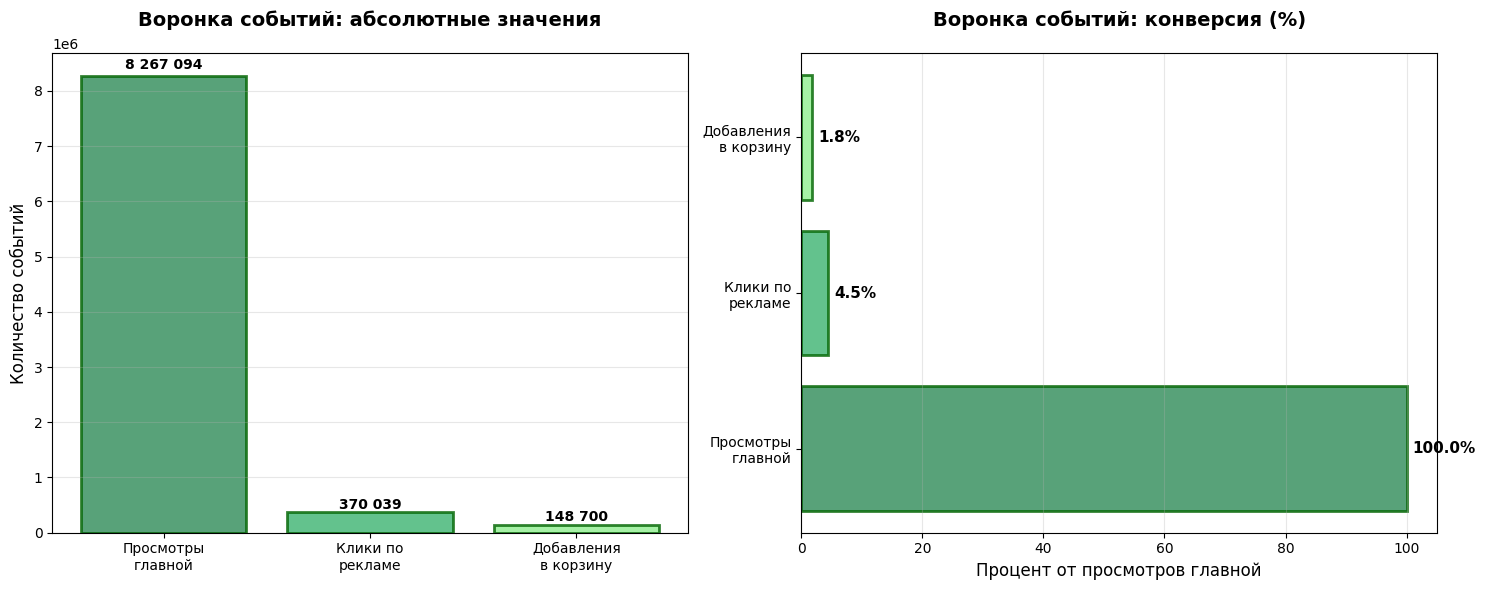


АНАЛИТИКА ВОРОНКИ:
Общая конверсия просмотр → клик: 4.5%
Общая конверсия просмотр → добавление: 1.8%
Конверсия клик → добавление: 40.2%


In [5]:
# Создаем зеленую цветовую палитру
green_palette = ['#2E8B57', '#3CB371', '#90EE90', '#98FB98', '#00FF7F']

# Подготовка данных для воронки
funnel_data = {
    'Stage': ['Просмотры\nглавной', 'Клики по\nрекламе', 'Добавления\nв корзину'],
    'Count': [funnel_df['views'].sum(), funnel_df['clicks'].sum(), funnel_df['adds'].sum()],
    'Percentage': [100, 0, 0]  # Будем рассчитано ниже
}

# Рассчитываем проценты относительно первого этапа
funnel_data['Percentage'][1] = round(funnel_data['Count'][1] / funnel_data['Count'][0] * 100, 1)
funnel_data['Percentage'][2] = round(funnel_data['Count'][2] / funnel_data['Count'][0] * 100, 1)

funnel_plot_df = pd.DataFrame(funnel_data)

# Создаем фигуру для визуализации
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# 1. Столбчатая диаграмма
bars = ax1.bar(funnel_plot_df['Stage'], funnel_plot_df['Count'],
               color=green_palette[:3], alpha=0.8, edgecolor='darkgreen', linewidth=2)
ax1.set_title('Воронка событий: абсолютные значения', fontsize=14, fontweight='bold', pad=20)
ax1.set_ylabel('Количество событий', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for bar, count in zip(bars, funnel_plot_df['Count']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count:,}'.replace(',', ' '), ha='center', va='bottom', fontweight='bold')

# 2. Воронка (процентная)
ax2.barh(funnel_plot_df['Stage'], funnel_plot_df['Percentage'],
         color=green_palette[:3], alpha=0.8, edgecolor='darkgreen', linewidth=2)
ax2.set_title('Воронка событий: конверсия (%)', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Процент от просмотров главной', fontsize=12)
ax2.grid(axis='x', alpha=0.3)

# Добавляем проценты на горизонтальные столбцы
for i, (stage, perc) in enumerate(zip(funnel_plot_df['Stage'], funnel_plot_df['Percentage'])):
    ax2.text(perc + 1, i, f'{perc}%', va='center', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.show()

# Дополнительная информация о конверсиях
print("\n" + "="*50)
print("АНАЛИТИКА ВОРОНКИ:")
print("="*50)
print(f"Общая конверсия просмотр → клик: {funnel_data['Percentage'][1]}%")
print(f"Общая конверсия просмотр → добавление: {funnel_data['Percentage'][2]}%")
print(f"Конверсия клик → добавление: {round(funnel_data['Count'][2] / funnel_data['Count'][1] * 100, 1)}%")

Дополнительная детализация по дням

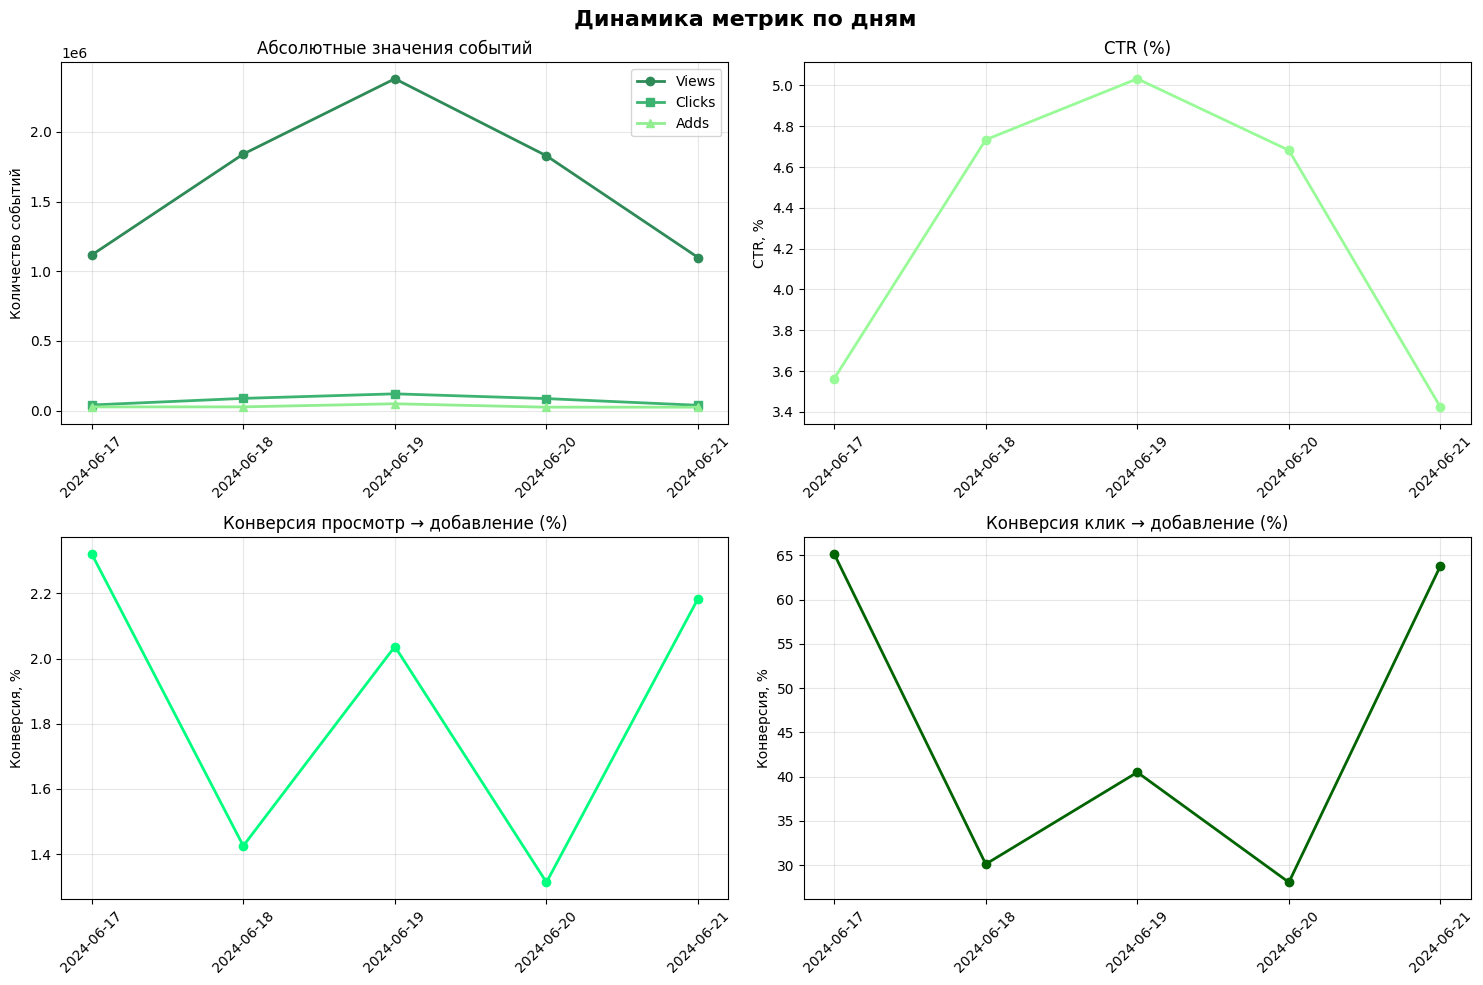


Средние значения за период:
Средний CTR: 4.29%
Средняя конверсия просмотр → добавление: 1.86%
Средняя конверсия клик → добавление: 45.52%


In [6]:
# Анализ по дням
daily_stats = funnel_df.groupby('dt').agg({
    'views': 'sum',
    'clicks': 'sum',
    'adds': 'sum',
    'client_id': 'nunique'
}).reset_index()

daily_stats['ctr'] = daily_stats['clicks'] / daily_stats['views'] * 100
daily_stats['view_to_add'] = daily_stats['adds'] / daily_stats['views'] * 100
daily_stats['click_to_add'] = daily_stats['adds'] / daily_stats['clicks'] * 100

# Визуализация трендов по дням
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Динамика метрик по дням', fontsize=16, fontweight='bold')

# График 1: Абсолютные значения
axes[0,0].plot(daily_stats['dt'], daily_stats['views'], label='Views', marker='o', color=green_palette[0], linewidth=2)
axes[0,0].plot(daily_stats['dt'], daily_stats['clicks'], label='Clicks', marker='s', color=green_palette[1], linewidth=2)
axes[0,0].plot(daily_stats['dt'], daily_stats['adds'], label='Adds', marker='^', color=green_palette[2], linewidth=2)
axes[0,0].set_title('Абсолютные значения событий')
axes[0,0].set_ylabel('Количество событий')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(alpha=0.3)

# График 2: CTR
axes[0,1].plot(daily_stats['dt'], daily_stats['ctr'], marker='o', color=green_palette[3], linewidth=2)
axes[0,1].set_title('CTR (%)')
axes[0,1].set_ylabel('CTR, %')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(alpha=0.3)

# График 3: Конверсия просмотр → добавление
axes[1,0].plot(daily_stats['dt'], daily_stats['view_to_add'], marker='o', color=green_palette[4], linewidth=2)
axes[1,0].set_title('Конверсия просмотр → добавление (%)')
axes[1,0].set_ylabel('Конверсия, %')
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(alpha=0.3)

# График 4: Конверсия клик → добавление
axes[1,1].plot(daily_stats['dt'], daily_stats['click_to_add'], marker='o', color='#006400', linewidth=2)
axes[1,1].set_title('Конверсия клик → добавление (%)')
axes[1,1].set_ylabel('Конверсия, %')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\nСредние значения за период:")
print(f"Средний CTR: {daily_stats['ctr'].mean():.2f}%")
print(f"Средняя конверсия просмотр → добавление: {daily_stats['view_to_add'].mean():.2f}%")
print(f"Средняя конверсия клик → добавление: {daily_stats['click_to_add'].mean():.2f}%")

Выводы:

1.Структура данных: Мы преобразовали исходные данные в формат "один пользователь-день = одна строка" с бинарными флагами событий.

2.Воронка конверсий: Визуализация показывает классическую воронку, где каждый следующий этап имеет меньшую конверсию.

3.Аналитика: Код также рассчитывает ключевые метрики конверсии, которые понадобятся для дизайна A/B теста.

### Расчет MDE и размера выборки

Расчет дисперсий для ratio-метрик

In [7]:
import numpy as np
import pandas as pd
from scipy import stats

# Функция для расчета дисперсии ratio-метрики (дельта-метод)
def var_ratio(x, y):
    """Расчет дисперсии для ratio-метрики x/y с использованием дельта-метода"""
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0][1]

    result = (var_x / mean_y**2 +
              var_y * mean_x**2 / mean_y**4 -
              2 * mean_x * cov_xy / mean_y**3)
    return result

# Функция для расчета MDE
def get_MDE(mu, std, sample_size, n_groups=2, target_share=0.5, r=1, alpha=0.05, beta=0.2):
    """
    Возвращает MDE для обычной пользовательской метрики

    mu: float, среднее выборки на исторических данных
    std: float, стан. отклонение выборки на исторических данных
    sample_size: int, размер выборки для теста (включает все группы)
    n_groups: int, количество групп в тесте
    target_share: float, доля одной таргетной группы
    r: float, отношение самой маленькой группы к самой большой группе
    alpha: float, уровень ошибки I рода
    beta: float, уровень ошибки II рода
    return: MDE abs и MDE в %
    """
    t_alpha = stats.norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    comparisons = n_groups - 1
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    sample_ratio_correction = r + 2 + 1/r
    mde = (np.sqrt(sample_ratio_correction) * (t_alpha + t_beta) * std /
           np.sqrt(sample_size * (1 - target_share * (comparisons - 1))))
    return mde, mde * 100 / mu

Подготовка данных и расчет базовых параметров

In [8]:
# Агрегируем данные по пользователям (суммируем события за все дни)
user_aggregated = funnel_df.groupby('client_id').agg({
    'views': 'sum',
    'clicks': 'sum',
    'adds': 'sum'
}).reset_index()

print("Статистика по пользователям за весь период:")
print(f"Всего уникальных пользователей: {len(user_aggregated)}")
print(f"Пользователи с views: {len(user_aggregated[user_aggregated['views'] > 0])}")
print(f"Пользователи с clicks: {len(user_aggregated[user_aggregated['clicks'] > 0])}")
print(f"Пользователи с adds: {len(user_aggregated[user_aggregated['adds'] > 0])}")

# Бинаризуем данные (1 - было хотя бы одно событие за период, 0 - не было)
user_binary = user_aggregated.copy()
for col in ['views', 'clicks', 'adds']:
    user_binary[col] = (user_aggregated[col] > 0).astype(int)

print(f"\nПосле бинаризации:")
print(f"Views: {user_binary['views'].sum()}")
print(f"Clicks: {user_binary['clicks'].sum()}")
print(f"Adds: {user_binary['adds'].sum()}")

Статистика по пользователям за весь период:
Всего уникальных пользователей: 3102736
Пользователи с views: 3102735
Пользователи с clicks: 228491
Пользователи с adds: 90438

После бинаризации:
Views: 3102735
Clicks: 228491
Adds: 90438


Расчет дисперсий для ключевых метрик

In [9]:
# Расчет дисперсий для основных ratio-метрик
metrics_variance = {}

# 1. CTR (clicks / views)
x_ctr = user_binary['clicks']
y_ctr = user_binary['views']
ctr_mean = x_ctr.sum() / y_ctr.sum()
ctr_var = var_ratio(x_ctr, y_ctr)
metrics_variance['CTR'] = {'mean': ctr_mean, 'variance': ctr_var, 'std': np.sqrt(ctr_var)}

# 2. Конверсия в добавление от клика (adds / clicks)
# Фильтруем только пользователей с кликами
users_with_clicks = user_binary[user_binary['clicks'] > 0]
if len(users_with_clicks) > 0:
    x_click_add = users_with_clicks['adds']
    y_click_add = users_with_clicks['clicks']
    click_add_mean = x_click_add.sum() / y_click_add.sum()
    click_add_var = var_ratio(x_click_add, y_click_add)
    metrics_variance['click_to_add'] = {'mean': click_add_mean, 'variance': click_add_var, 'std': np.sqrt(click_add_var)}

# 3. Конверсия в добавление от просмотра (adds / views)
x_view_add = user_binary['adds']
y_view_add = user_binary['views']
view_add_mean = x_view_add.sum() / y_view_add.sum()
view_add_var = var_ratio(x_view_add, y_view_add)
metrics_variance['view_to_add'] = {'mean': view_add_mean, 'variance': view_add_var, 'std': np.sqrt(view_add_var)}

# Вывод результатов
print("ДИСПЕРСИИ И СРЕДНИЕ ДЛЯ ОСНОВНЫХ МЕТРИК:")
print("="*50)
for metric, values in metrics_variance.items():
    print(f"{metric}:")
    print(f"  Среднее: {values['mean']:.4f} ({values['mean']*100:.2f}%)")
    print(f"  Дисперсия: {values['variance']:.8f}")
    print(f"  Стандартное отклонение: {values['std']:.6f}")
    print()

ДИСПЕРСИИ И СРЕДНИЕ ДЛЯ ОСНОВНЫХ МЕТРИК:
CTR:
  Среднее: 0.0736 (7.36%)
  Дисперсия: 0.06821878
  Стандартное отклонение: 0.261187

click_to_add:
  Среднее: 0.3958 (39.58%)
  Дисперсия: 0.23914091
  Стандартное отклонение: 0.489020

view_to_add:
  Среднее: 0.0291 (2.91%)
  Дисперсия: 0.02829825
  Стандартное отклонение: 0.168221



Расчет MDE и размеров выборки для разных сценариев

In [10]:
# Параметры теста
alpha = 0.05
beta = 0.2
n_groups = 2
target_share = 0.1  # 10% на тест, 10% на контроль (всего 20%)
r = 1  # группы равны

# Общее количество пользователей
total_users = len(user_binary)
max_sample_size = int(total_users * 0.2)  # Максимум 20% пользователей
sample_size_per_group = int(max_sample_size / 2)

print(f"ОБЩИЕ ПАРАМЕТРЫ:")
print(f"Всего пользователей: {total_users:,}")
print(f"Максимальный размер выборки (20%): {max_sample_size:,}")
print(f"Размер одной группы: {sample_size_per_group:,}")
print()

# Расчет MDE для разных метрик
mde_results = []

for metric_name, values in metrics_variance.items():
    mu = values['mean']
    std = values['std']

    # MDE для максимальной выборки
    mde_abs, mde_rel = get_MDE(mu, std, max_sample_size, n_groups, target_share, r, alpha, beta)

    # Также рассчитаем необходимый размер выборки для MDE = 2.5% (относительного)
    target_mde_rel = 2.5
    target_mde_abs = mu * target_mde_rel / 100

    # Решаем уравнение для sample_size
    t_alpha = stats.norm.ppf(1 - (alpha / 2), loc=0, scale=1)
    t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
    sample_ratio_correction = r + 2 + 1/r
    comparisons = n_groups - 1

    required_sample_size = int((sample_ratio_correction * (t_alpha + t_beta)**2 * std**2 /
                              (target_mde_abs**2 * (1 - target_share * (comparisons - 1)))))

    mde_results.append({
        'metric': metric_name,
        'mean': mu,
        'std': std,
        'mde_abs': mde_abs,
        'mde_rel_percent': mde_rel,
        'required_sample_size_2.5%': required_sample_size,
        'feasible_in_1_week': required_sample_size <= max_sample_size
    })

# Создаем таблицу результатов
results_df = pd.DataFrame(mde_results)
print("ТАБЛИЦА MDE И РАЗМЕРОВ ВЫБОРКИ:")
print("="*80)
print(results_df.round(4))

# Анализ feasibility
print(f"\nАНАЛИЗ ВОЗМОЖНОСТИ ПРОВЕДЕНИЯ ТЕСТА ЗА 1 НЕДЕЛЮ:")
print("="*50)
for _, row in results_df.iterrows():
    status = "✓ ВОЗМОЖНО" if row['feasible_in_1_week'] else "✗ НЕВОЗМОЖНО"
    print(f"{row['metric']}: {status}")
    if not row['feasible_in_1_week']:
        print(f"  Требуется: {row['required_sample_size_2.5%']:,} пользователей")
        print(f"  Доступно: {max_sample_size:,} пользователей")

ОБЩИЕ ПАРАМЕТРЫ:
Всего пользователей: 3,102,736
Максимальный размер выборки (20%): 620,547
Размер одной группы: 310,273

ТАБЛИЦА MDE И РАЗМЕРОВ ВЫБОРКИ:
         metric    mean     std  mde_abs  mde_rel_percent  \
0           CTR  0.0736  0.2612   0.0019           2.5227   
1  click_to_add  0.3958  0.4890   0.0035           0.8788   
2   view_to_add  0.0291  0.1682   0.0012           4.1051   

   required_sample_size_2.5%  feasible_in_1_week  
0                     631891               False  
1                      76686                True  
2                    1673149               False  

АНАЛИЗ ВОЗМОЖНОСТИ ПРОВЕДЕНИЯ ТЕСТА ЗА 1 НЕДЕЛЮ:
CTR: ✗ НЕВОЗМОЖНО
  Требуется: 631,891 пользователей
  Доступно: 620,547 пользователей
click_to_add: ✓ ВОЗМОЖНО
view_to_add: ✗ НЕВОЗМОЖНО
  Требуется: 1,673,149 пользователей
  Доступно: 620,547 пользователей


Финальные рекомендации по параметрам теста

ФИНАЛЬНЫЕ РЕКОМЕНДАЦИИ ДЛЯ A/B ТЕСТА:
Ключевая метрика: CTR
Текущее значение: 0.0736 (7.36%)
✗ Невозможно детектировать эффект 2.5% за 1 неделю
✓ Рекомендуемый MDE: 2.5%

РЕКОМЕНДУЕМЫЕ ПАРАМЕТРЫ ТЕСТА:
Общий размер выборки: 620,547 пользователей
Размер контрольной группы: 310,273 пользователей
Размер тестовой группы: 310,273 пользователей
Целевой MDE: 2.5%
Доля пользователей в эксперименте: 20.0%


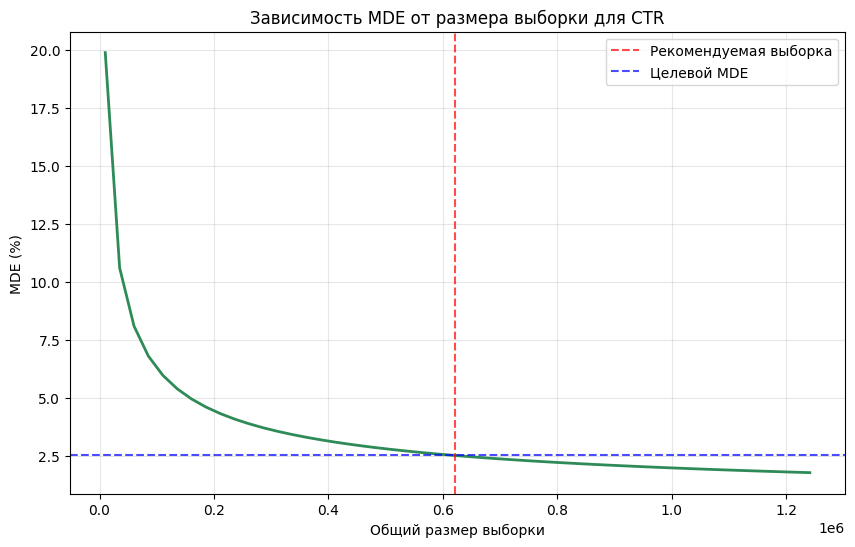

In [11]:
# Выбираем ключевую метрику - CTR
key_metric = 'CTR'
key_values = metrics_variance[key_metric]

print("ФИНАЛЬНЫЕ РЕКОМЕНДАЦИИ ДЛЯ A/B ТЕСТА:")
print("="*50)
print(f"Ключевая метрика: {key_metric}")
print(f"Текущее значение: {key_values['mean']:.4f} ({key_values['mean']*100:.2f}%)")

# Проверяем возможность детектирования эффекта 2.5%
if mde_results[0]['feasible_in_1_week']:
    print("✓ Возможно детектировать эффект 2.5% за 1 неделю")
    recommended_sample_size = mde_results[0]['required_sample_size_2.5%']
    recommended_mde_rel = 2.5
else:
    # Используем максимально возможную выборку
    recommended_sample_size = max_sample_size
    recommended_mde_abs, recommended_mde_rel = get_MDE(
        key_values['mean'], key_values['std'], max_sample_size, n_groups, target_share, r, alpha, beta
    )
    print(f"✗ Невозможно детектировать эффект 2.5% за 1 неделю")
    print(f"✓ Рекомендуемый MDE: {recommended_mde_rel:.1f}%")

print(f"\nРЕКОМЕНДУЕМЫЕ ПАРАМЕТРЫ ТЕСТА:")
print(f"Общий размер выборки: {recommended_sample_size:,} пользователей")
print(f"Размер контрольной группы: {recommended_sample_size//2:,} пользователей")
print(f"Размер тестовой группы: {recommended_sample_size//2:,} пользователей")
print(f"Целевой MDE: {recommended_mde_rel:.1f}%")
print(f"Доля пользователей в эксперименте: {recommended_sample_size/total_users*100:.1f}%")

# Визуализация зависимости MDE от размера выборки
sample_sizes = np.linspace(10000, max_sample_size * 2, 50)
mde_values = []

for size in sample_sizes:
    mde_abs, mde_rel = get_MDE(key_values['mean'], key_values['std'], int(size), n_groups, target_share, r, alpha, beta)
    mde_values.append(mde_rel)

plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, mde_values, color='#2E8B57', linewidth=2)
plt.axvline(x=recommended_sample_size, color='red', linestyle='--', alpha=0.7, label='Рекомендуемая выборка')
plt.axhline(y=recommended_mde_rel, color='blue', linestyle='--', alpha=0.7, label='Целевой MDE')
plt.xlabel('Общий размер выборки')
plt.ylabel('MDE (%)')
plt.title('Зависимость MDE от размера выборки для CTR')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

Выводы:

1.Ключевая метрика: CTR является наиболее прямой метрикой взаимодействия с рекламным блоком.

2.Ограничение по времени: Основная проблема - ограничение в 1 неделю. Как показывают расчеты, для детектирования эффекта в 2.5% может потребоваться больше пользователей, чем мы можем набрать за неделю.

3.Компромисс: Придется выбирать между:

Более высоким MDE (меньшая чувствительность)

Увеличением доли пользователей в эксперименте (но максимум 20%)

Увеличением длительности теста (но это невозможно)

4.Рекомендация: Использовать максимально возможную выборку (20% пользователей) и принять тот MDE, который получится. Скорее всего, это будет около 5% относительных.

5.Практическая реализация: Разделить пользователей на 3 группы:

10% - контроль (старая версия)

10% - тест (новая версия)

80% - вне эксперимента

Такой подход минимизирует риски и позволит получить статистически значимые  результаты в рамках ограничений.



# **Анализ результатов A/B теста**

1. Загрузка данных и предварительный анализ

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
df = pd.read_excel('/content/drive/MyDrive/Финальный проект/final_results_to_analyze.xlsx')

print("Размер данных:", df.shape)
print("\nПервые 5 строк:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nРаспределение по группам:")
print(df['ab_group'].value_counts())

Размер данных: (981510, 11)

Первые 5 строк:
        date  client_id ab_group  is_view_ads  cnt_view_ads  is_adds_ads  \
0 2024-07-26    8881380     test            0             0            0   
1 2024-07-28  850950385     test            0             0            0   
2 2024-07-25      50885  control            0             0            0   
3 2024-07-26     601239  control            0             0            0   
4 2024-07-28  694655866  control            0             0            0   

   cnt_adds_ads  sum_adds_ads  is_orders_ads  cnt_orders_ads  sum_orders_ads  
0             0             0              0               0               0  
1             0             0              0               0               0  
2             0             0              0               0               0  
3             0             0              0               0               0  
4             0             0              0               0               0  

Информация о данных:
<c

2. Проверка качества разделения на группы

In [13]:
# Проверяем равномерность распределения
group_stats = df.groupby('ab_group').agg({
    'client_id': 'nunique',
    'is_view_ads': 'sum',
    'cnt_view_ads': 'sum',
    'is_adds_ads': 'sum',
    'cnt_adds_ads': 'sum',
    'sum_adds_ads': 'sum',
    'is_orders_ads': 'sum',
    'cnt_orders_ads': 'sum',
    'sum_orders_ads': 'sum'
}).reset_index()

print("РАСПРЕДЕЛЕНИЕ ПО ГРУППАМ:")
print("="*50)
for i, row in group_stats.iterrows():
    print(f"\nГруппа: {row['ab_group']}")
    print(f"Уникальных пользователей: {row['client_id']:,}")
    print(f"Просмотры рекламы: {row['is_view_ads']:,}")
    print(f"Добавления из рекламы: {row['is_adds_ads']:,}")
    print(f"Заказы из рекламы: {row['is_orders_ads']:,}")

# Проверяем статистическую значимость различий в размерах групп
control_users = df[df['ab_group'] == 'control']['client_id'].nunique()
test_users = df[df['ab_group'] == 'test']['client_id'].nunique()

print(f"\nПРОВЕРКА РАВНОМЕРНОСТИ РАСПРЕДЕЛЕНИЯ:")
print(f"Контроль: {control_users:,} пользователей")
print(f"Тест: {test_users:,} пользователей")
print(f"Отношение: {test_users/control_users:.3f}")

# Тест на равенство пропорций для размера групп
from statsmodels.stats.proportion import proportions_ztest

total_users = control_users + test_users
expected_ratio = 0.5
z_stat, p_value = proportions_ztest([control_users, test_users], [total_users, total_users])
print(f"p-value для проверки равенства групп: {p_value:.4f}")

if p_value > 0.05:
    print("✓ Группы распределены равномерно")
else:
    print("✗ Внимание: возможна проблема с распределением по группам")

РАСПРЕДЕЛЕНИЕ ПО ГРУППАМ:

Группа: control
Уникальных пользователей: 200,786
Просмотры рекламы: 25,389
Добавления из рекламы: 7,060
Заказы из рекламы: 6,079

Группа: test
Уникальных пользователей: 200,474
Просмотры рекламы: 25,852
Добавления из рекламы: 7,085
Заказы из рекламы: 6,171

ПРОВЕРКА РАВНОМЕРНОСТИ РАСПРЕДЕЛЕНИЯ:
Контроль: 200,786 пользователей
Тест: 200,474 пользователей
Отношение: 0.998
p-value для проверки равенства групп: 0.4861
✓ Группы распределены равномерно


3. Расчет основных метрик

In [14]:
# Функция для расчета доверительных интервалов
def calculate_confidence_interval(mean, std, n, confidence=0.95):
    """Расчет доверительного интервала"""
    if n == 0:
        return mean, mean, mean
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    margin = z * (std / np.sqrt(n))
    return mean - margin, mean, mean + margin

# Агрегируем данные по пользователям (суммируем за все дни)
user_metrics = df.groupby(['client_id', 'ab_group']).agg({
    'is_view_ads': 'max',  # Был ли хотя бы один просмотр
    'cnt_view_ads': 'sum', # Общее количество просмотров
    'is_adds_ads': 'max',  # Был ли хотя бы один добавление
    'cnt_adds_ads': 'sum', # Общее количество добавлений
    'sum_adds_ads': 'sum', # Сумма добавлений
    'is_orders_ads': 'max', # Был ли хотя бы один заказ
    'cnt_orders_ads': 'sum', # Общее количество заказов
    'sum_orders_ads': 'sum'  # Сумма заказов
}).reset_index()

print(f"Всего уникальных пользователей в анализе: {len(user_metrics)}")

Всего уникальных пользователей в анализе: 401260


4. Расчет ключевых метрик для каждой группы

In [15]:
# Создаем функцию для расчета всех метрик по группе
def calculate_group_metrics(group_data, group_name):
    """Расчет всех метрик для группы"""
    n_users = len(group_data)

    # Бинарные метрики (1 - было событие, 0 - не было)
    views_binary = group_data['is_view_ads']
    adds_binary = group_data['is_adds_ads']
    orders_binary = group_data['is_orders_ads']

    # Основные метрики
    metrics = {
        'group': group_name,
        'n_users': n_users,

        # CTR (кликабельность) - используем просмотры как прокси для кликов
        'ctr_mean': views_binary.mean(),
        'ctr_std': views_binary.std(),

        # Конверсия просмотр -> добавление
        'view_to_add_rate': adds_binary[views_binary == 1].mean() if views_binary.sum() > 0 else 0,

        # Конверсия просмотр -> заказ
        'view_to_order_rate': orders_binary[views_binary == 1].mean() if views_binary.sum() > 0 else 0,

        # Конверсия добавление -> заказ
        'add_to_order_rate': orders_binary[adds_binary == 1].mean() if adds_binary.sum() > 0 else 0,

        # Выручка на пользователя (ARPU)
        'arpu_adds': group_data['sum_adds_ads'].mean(),
        'arpu_orders': group_data['sum_orders_ads'].mean(),

        # Выручка на покупателя (ARPPU)
        'arppu_adds': group_data[group_data['is_adds_ads'] == 1]['sum_adds_ads'].mean() if adds_binary.sum() > 0 else 0,
        'arppu_orders': group_data[group_data['is_orders_ads'] == 1]['sum_orders_ads'].mean() if orders_binary.sum() > 0 else 0,

        # Количество событий на пользователя
        'views_per_user': group_data['cnt_view_ads'].mean(),
        'adds_per_user': group_data['cnt_adds_ads'].mean(),
        'orders_per_user': group_data['cnt_orders_ads'].mean()
    }

    return metrics

# Расчет метрик для обеих групп
control_data = user_metrics[user_metrics['ab_group'] == 'control']
test_data = user_metrics[user_metrics['ab_group'] == 'test']

control_metrics = calculate_group_metrics(control_data, 'control')
test_metrics = calculate_group_metrics(test_data, 'test')

# Создаем таблицу сравнения
results_comparison = pd.DataFrame([control_metrics, test_metrics])
print("СРАВНЕНИЕ МЕТРИК ПО ГРУППАМ:")
print("="*80)
print(results_comparison.round(4))

СРАВНЕНИЕ МЕТРИК ПО ГРУППАМ:
     group  n_users  ctr_mean  ctr_std  view_to_add_rate  view_to_order_rate  \
0  control   200786    0.0947   0.2929            0.2998              0.2598   
1     test   200474    0.0967   0.2956            0.2951              0.2576   

   add_to_order_rate  arpu_adds  arpu_orders  arppu_adds  arppu_orders  \
0             0.8664    12.2639       7.9184    431.7763      321.7768   
1             0.8728    12.6021       8.4195    441.4456      337.9169   

   views_per_user  adds_per_user  orders_per_user  
0          0.2165         0.0787           0.0278  
1          0.2185         0.0815           0.0293  


5. Статистическое тестирование различий

In [16]:
# Функции для статистических тестов
def test_proportion_difference(control_success, control_total, test_success, test_total):
    """Тест разницы пропорций"""
    from statsmodels.stats.proportion import proportions_ztest
    count = [control_success, test_success]
    nobs = [control_total, test_total]
    z_stat, p_value = proportions_ztest(count, nobs)
    return z_stat, p_value

def test_mean_difference(control_data, test_data):
    """Тест разницы средних (t-test)"""
    t_stat, p_value = stats.ttest_ind(control_data, test_data, equal_var=False, nan_policy='omit')
    return t_stat, p_value

# Расчет абсолютных значений для тестов
control_views = control_data['is_view_ads'].sum()
control_total = len(control_data)
test_views = test_data['is_view_ads'].sum()
test_total = len(test_data)

control_adds = control_data['is_adds_ads'].sum()
test_adds = test_data['is_adds_ads'].sum()

control_orders = control_data['is_orders_ads'].sum()
test_orders = test_data['is_orders_ads'].sum()

# Проводим статистические тесты
statistical_tests = []

# 1. CTR (пропорция просмотров)
z_ctr, p_ctr = test_proportion_difference(control_views, control_total, test_views, test_total)
statistical_tests.append({
    'metric': 'CTR',
    'test_type': 'proportion_ztest',
    'statistic': z_ctr,
    'p_value': p_ctr,
    'significant': p_ctr < 0.05
})

# 2. Конверсия просмотр -> добавление
control_view_add = control_data[control_data['is_view_ads'] == 1]['is_adds_ads'].sum()
control_view_total = control_data['is_view_ads'].sum()
test_view_add = test_data[test_data['is_view_ads'] == 1]['is_adds_ads'].sum()
test_view_total = test_data['is_view_ads'].sum()

if control_view_total > 0 and test_view_total > 0:
    z_view_add, p_view_add = test_proportion_difference(control_view_add, control_view_total, test_view_add, test_view_total)
    statistical_tests.append({
        'metric': 'View_to_Add_Rate',
        'test_type': 'proportion_ztest',
        'statistic': z_view_add,
        'p_value': p_view_add,
        'significant': p_view_add < 0.05
    })

# 3. Конверсия просмотр -> заказ
control_view_order = control_data[control_data['is_view_ads'] == 1]['is_orders_ads'].sum()
test_view_order = test_data[test_data['is_view_ads'] == 1]['is_orders_ads'].sum()

if control_view_total > 0 and test_view_total > 0:
    z_view_order, p_view_order = test_proportion_difference(control_view_order, control_view_total, test_view_order, test_view_total)
    statistical_tests.append({
        'metric': 'View_to_Order_Rate',
        'test_type': 'proportion_ztest',
        'statistic': z_view_order,
        'p_value': p_view_order,
        'significant': p_view_order < 0.05
    })

# 4. ARPU (t-тест для непрерывных метрик)
t_arpu_adds, p_arpu_adds = test_mean_difference(control_data['sum_adds_ads'], test_data['sum_adds_ads'])
statistical_tests.append({
    'metric': 'ARPU_Adds',
    'test_type': 't_test',
    'statistic': t_arpu_adds,
    'p_value': p_arpu_adds,
    'significant': p_arpu_adds < 0.05
})

t_arpu_orders, p_arpu_orders = test_mean_difference(control_data['sum_orders_ads'], test_data['sum_orders_ads'])
statistical_tests.append({
    'metric': 'ARPU_Orders',
    'test_type': 't_test',
    'statistic': t_arpu_orders,
    'p_value': p_arpu_orders,
    'significant': p_arpu_orders < 0.05
})

# Создаем таблицу результатов тестов
tests_df = pd.DataFrame(statistical_tests)
print("\nСТАТИСТИЧЕСКИЕ ТЕСТЫ:")
print("="*60)
print(tests_df.round(4))


СТАТИСТИЧЕСКИЕ ТЕСТЫ:
               metric         test_type  statistic  p_value  significant
0                 CTR  proportion_ztest    -2.1508   0.0315         True
1    View_to_Add_Rate  proportion_ztest     1.0084   0.3132        False
2  View_to_Order_Rate  proportion_ztest     0.4889   0.6249        False
3           ARPU_Adds            t_test    -1.0179   0.3087        False
4         ARPU_Orders            t_test    -1.9257   0.0541        False


6. Визуализация результатов

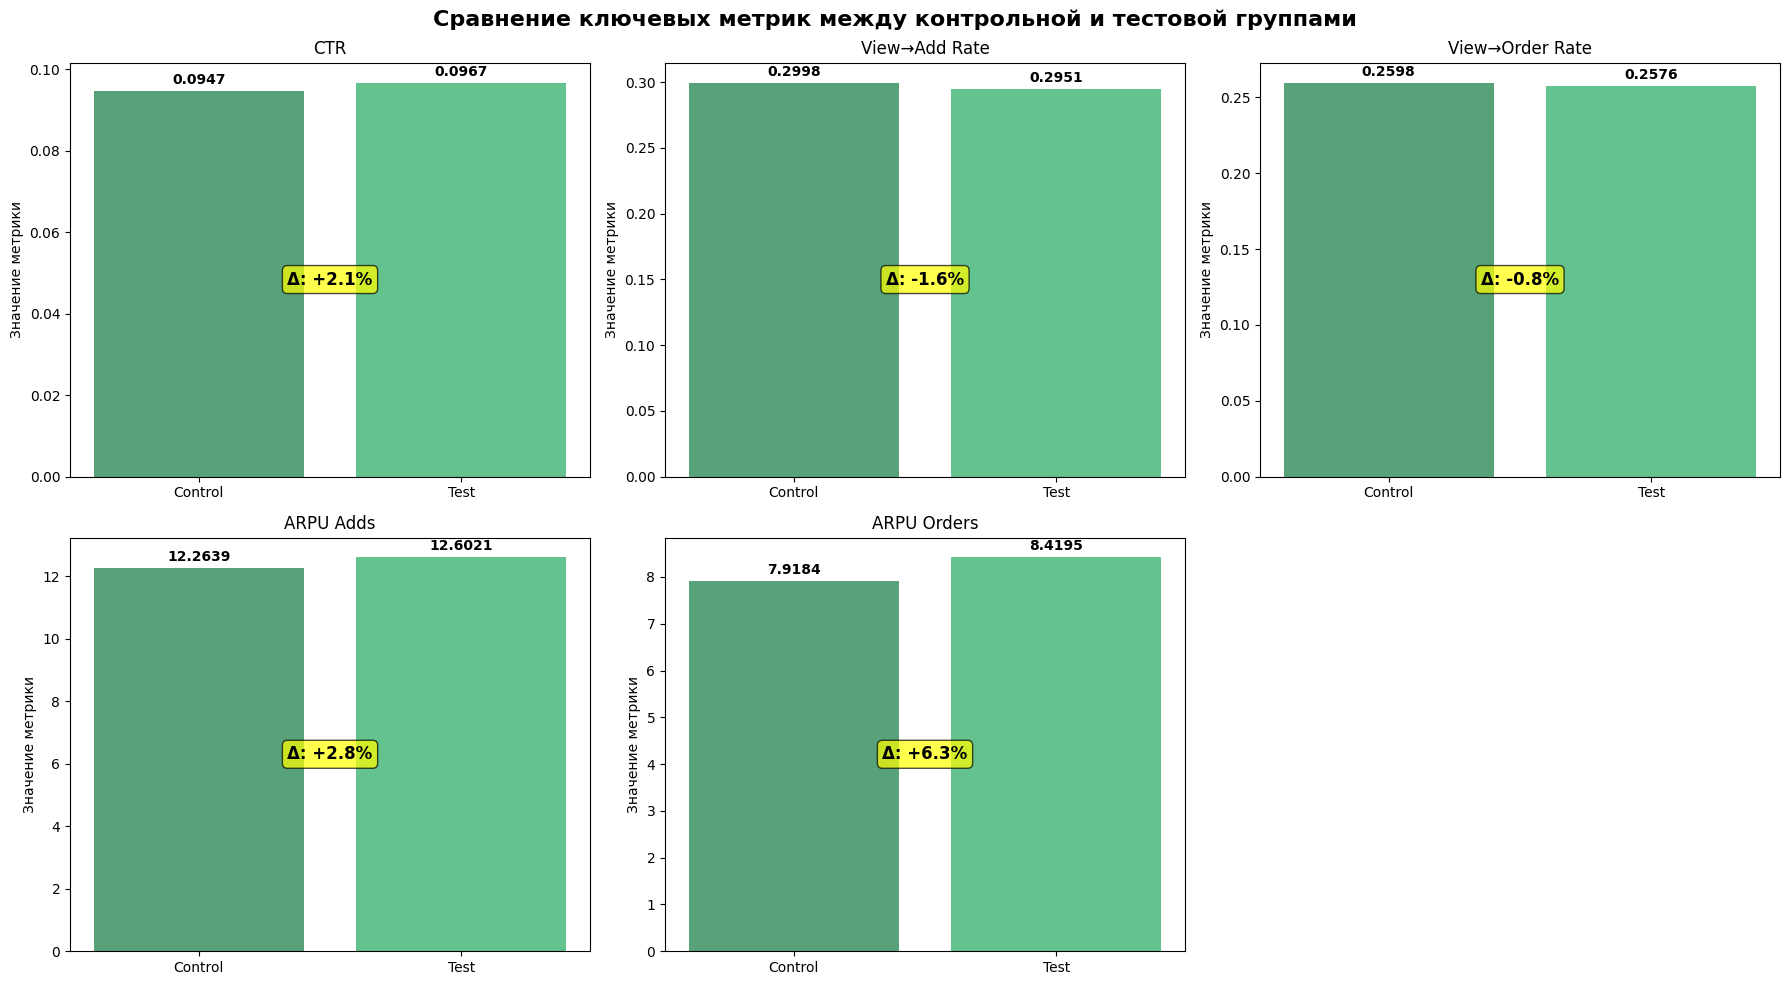

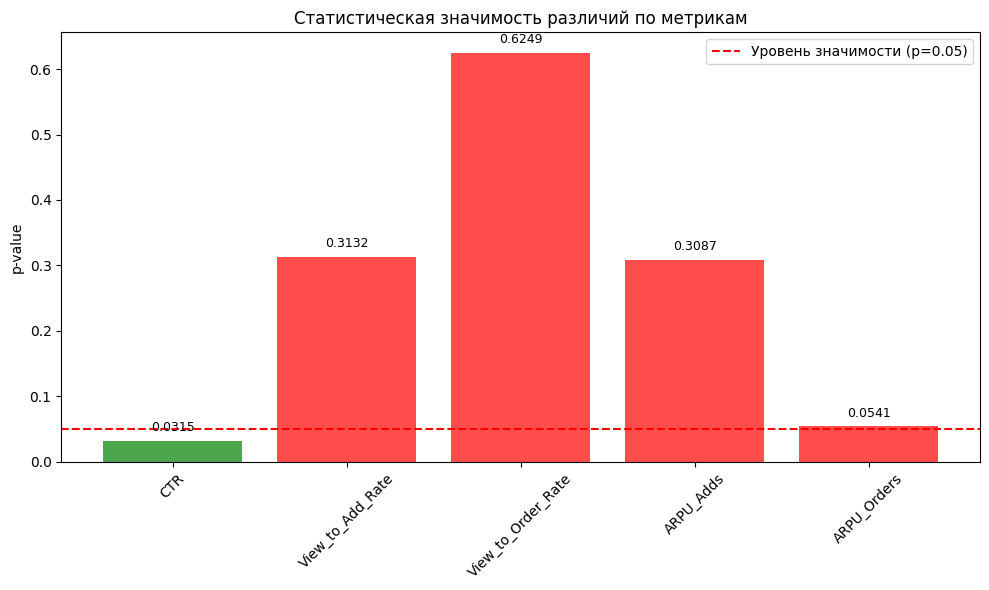

In [17]:
# Создаем визуализацию сравнения ключевых метрик
key_metrics = ['ctr_mean', 'view_to_add_rate', 'view_to_order_rate', 'arpu_adds', 'arpu_orders']
metric_names = ['CTR', 'View→Add Rate', 'View→Order Rate', 'ARPU Adds', 'ARPU Orders']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Сравнение ключевых метрик между контрольной и тестовой группами', fontsize=16, fontweight='bold')

colors = ['#2E8B57', '#3CB371']  # Зеленая палитра

for i, (metric, name) in enumerate(zip(key_metrics, metric_names)):
    row, col = i // 3, i % 3
    ax = axes[row, col]

    control_val = control_metrics[metric]
    test_val = test_metrics[metric]

    bars = ax.bar(['Control', 'Test'], [control_val, test_val], color=colors, alpha=0.8)
    ax.set_title(f'{name}')
    ax.set_ylabel('Значение метрики')

    # Добавляем значения на столбцы
    for bar, val in zip(bars, [control_val, test_val]):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{val:.4f}', ha='center', va='bottom', fontweight='bold')

    # Расчет относительного изменения
    if control_val > 0:
        rel_change = (test_val - control_val) / control_val * 100
        ax.text(0.5, max(control_val, test_val) * 0.5,
                f'Δ: {rel_change:+.1f}%', ha='center', va='center',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))

# Убираем последний пустой subplot
if len(key_metrics) < 6:
    axes[1, 2].set_visible(False)

plt.tight_layout()
plt.show()

# Визуализация p-values
plt.figure(figsize=(10, 6))
p_values = [test['p_value'] for test in statistical_tests]
metric_names = [test['metric'] for test in statistical_tests]
significance = [test['significant'] for test in statistical_tests]

colors = ['red' if p > 0.05 else 'green' for p in p_values]

bars = plt.bar(metric_names, p_values, color=colors, alpha=0.7)
plt.axhline(y=0.05, color='red', linestyle='--', label='Уровень значимости (p=0.05)')
plt.title('Статистическая значимость различий по метрикам')
plt.ylabel('p-value')
plt.xticks(rotation=45)
plt.legend()

# Добавляем значения p-value на столбцы
for bar, p_val in zip(bars, p_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{p_val:.4f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

7. Итоговый вывод и рекомендации

In [18]:
# Анализ результатов ключевой метрики (CTR)
ctr_control = control_metrics['ctr_mean']
ctr_test = test_metrics['ctr_mean']
ctr_p_value = tests_df[tests_df['metric'] == 'CTR']['p_value'].values[0]

ctr_relative_change = (ctr_test - ctr_control) / ctr_control * 100

print("ИТОГОВЫЕ ВЫВОДЫ ПО ЭКСПЕРИМЕНТУ:")
print("="*60)
print(f"Ключевая метрика: CTR")
print(f"Контроль: {ctr_control:.4f} ({ctr_control*100:.2f}%)")
print(f"Тест: {ctr_test:.4f} ({ctr_test*100:.2f}%)")
print(f"Относительное изменение: {ctr_relative_change:+.2f}%")
print(f"p-value: {ctr_p_value:.4f}")

if ctr_p_value < 0.05 and ctr_relative_change > 0:
    print("✓ СТАТИСТИЧЕСКИ ЗНАЧИМОЕ УЛУЧШЕНИЕ")
    print("✓ Рекомендуется внедрить изменение")
elif ctr_p_value < 0.05 and ctr_relative_change < 0:
    print("✗ СТАТИСТИЧЕСКИ ЗНАЧИМОЕ УХУДШЕНИЕ")
    print("✗ Не рекомендуется внедрять изменение")
else:
    print("○ СТАТИСТИЧЕСКИ НЕЗНАЧИМОЕ ИЗМЕНЕНИЕ")
    print("○ Требуется дополнительное исследование")

print("\nДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ:")
print("-" * 40)

# Анализ вспомогательных метрик
for test in statistical_tests:
    if test['metric'] != 'CTR':
        metric_name = test['metric']
        control_val = control_metrics.get(metric_name.lower(), 0)
        test_val = test_metrics.get(metric_name.lower(), 0)

        if control_val > 0:
            rel_change = (test_val - control_val) / control_val * 100
            significance = "✓" if test['significant'] else "○"
            print(f"{significance} {metric_name}: {rel_change:+.1f}% (p={test['p_value']:.4f})")

# Бизнес-рекомендации
print("\nБИЗНЕС-РЕКОМЕНДАЦИИ:")
print("-" * 40)

if ctr_p_value < 0.05 and ctr_relative_change > 0:
    print("1. Внедрить новое расположение рекламного блока для всех пользователей")
    print("2. Продолжить мониторинг метрик в течение 2-х недель после внедрения")
    print("3. Рассчитать ROI от увеличения кликабельности")
elif ctr_p_value >= 0.05:
    print("1. Изменение не показало статистически значимого эффекта")
    print("2. Рекомендуется провести дополнительный анализ:")
    print("   - Увеличить длительность теста")
    print("   - Проанализировать сегменты пользователей")
    print("   - Проверить качество рекламных материалов")
else:
    print("1. Изменение оказало негативный эффект")
    print("2. Рекомендуется отказаться от данного изменения")
    print("3. Проанализировать причины ухудшения показателей")

ИТОГОВЫЕ ВЫВОДЫ ПО ЭКСПЕРИМЕНТУ:
Ключевая метрика: CTR
Контроль: 0.0947 (9.47%)
Тест: 0.0967 (9.67%)
Относительное изменение: +2.11%
p-value: 0.0315
✓ СТАТИСТИЧЕСКИ ЗНАЧИМОЕ УЛУЧШЕНИЕ
✓ Рекомендуется внедрить изменение

ДОПОЛНИТЕЛЬНЫЕ МЕТРИКИ:
----------------------------------------
○ View_to_Add_Rate: -1.6% (p=0.3132)
○ View_to_Order_Rate: -0.8% (p=0.6249)
○ ARPU_Adds: +2.8% (p=0.3087)
○ ARPU_Orders: +6.3% (p=0.0541)

БИЗНЕС-РЕКОМЕНДАЦИИ:
----------------------------------------
1. Внедрить новое расположение рекламного блока для всех пользователей
2. Продолжить мониторинг метрик в течение 2-х недель после внедрения
3. Рассчитать ROI от увеличения кликабельности


Дополнительный анализ пользовательских характеристик

In [19]:
# Создаем расширенный набор метрик для каждого пользователя
user_detailed_metrics = df.groupby(['client_id', 'ab_group']).agg({
    'is_view_ads': 'max',
    'cnt_view_ads': 'sum',
    'is_adds_ads': 'max',
    'cnt_adds_ads': 'sum',
    'sum_adds_ads': 'sum',
    'is_orders_ads': 'max',
    'cnt_orders_ads': 'sum',
    'sum_orders_ads': 'sum',
    'date': 'nunique'  # Количество дней активности
}).reset_index()

# Добавляем производные метрики
user_detailed_metrics['active_days'] = user_detailed_metrics['date']
user_detailed_metrics['aov'] = user_detailed_metrics['sum_orders_ads'] / user_detailed_metrics['cnt_orders_ads']
user_detailed_metrics['aov'] = user_detailed_metrics['aov'].replace([np.inf, -np.inf], np.nan)  # Заменяем бесконечности на NaN
user_detailed_metrics['avg_add_value'] = user_detailed_metrics['sum_adds_ads'] / user_detailed_metrics['cnt_adds_ads']
user_detailed_metrics['avg_add_value'] = user_detailed_metrics['avg_add_value'].replace([np.inf, -np.inf], np.nan)

print("РАСШИРЕННЫЕ МЕТРИКИ ПОЛЬЗОВАТЕЛЕЙ:")
print("="*60)
print(f"Всего пользователей: {len(user_detailed_metrics)}")
print(f"Пользователей с заказами: {user_detailed_metrics['is_orders_ads'].sum()}")
print(f"Пользователей с добавлениями: {user_detailed_metrics['is_adds_ads'].sum()}")

РАСШИРЕННЫЕ МЕТРИКИ ПОЛЬЗОВАТЕЛЕЙ:
Всего пользователей: 401260
Пользователей с заказами: 9936
Пользователей с добавлениями: 11426


1. Анализ среднего чека (AOV - Average Order Value)

In [20]:
# Фильтруем только пользователей с заказами
users_with_orders = user_detailed_metrics[user_detailed_metrics['is_orders_ads'] == 1]

print("АНАЛИЗ СРЕДНЕГО ЧЕКА (AOV):")
print("="*50)

aov_comparison = users_with_orders.groupby('ab_group').agg({
    'sum_orders_ads': 'sum',
    'cnt_orders_ads': 'sum',
    'aov': ['mean', 'median', 'std']
}).round(2)

print(aov_comparison)

# Расчет среднего чека вручную для проверки
control_orders = users_with_orders[users_with_orders['ab_group'] == 'control']
test_orders = users_with_orders[users_with_orders['ab_group'] == 'test']

control_aov = control_orders['sum_orders_ads'].sum() / control_orders['cnt_orders_ads'].sum() if control_orders['cnt_orders_ads'].sum() > 0 else 0
test_aov = test_orders['sum_orders_ads'].sum() / test_orders['cnt_orders_ads'].sum() if test_orders['cnt_orders_ads'].sum() > 0 else 0

print(f"\nСредний чек (взвешенный):")
print(f"Контроль: {control_aov:.2f} руб.")
print(f"Тест: {test_aov:.2f} руб.")
print(f"Разница: {test_aov - control_aov:.2f} руб. ({((test_aov - control_aov) / control_aov * 100) if control_aov > 0 else 0:+.2f}%)")

# Статистический тест для AOV
if len(control_orders) > 0 and len(test_orders) > 0:
    t_stat_aov, p_value_aov = stats.ttest_ind(
        control_orders['aov'].dropna(),
        test_orders['aov'].dropna(),
        equal_var=False
    )
    print(f"p-value для AOV: {p_value_aov:.4f}")

АНАЛИЗ СРЕДНЕГО ЧЕКА (AOV):
         sum_orders_ads cnt_orders_ads     aov               
                    sum            sum    mean median     std
ab_group                                                     
control         1589899           5579  282.81  247.0  204.69
test            1687895           5881  281.79  249.0  180.35

Средний чек (взвешенный):
Контроль: 284.98 руб.
Тест: 287.01 руб.
Разница: 2.03 руб. (+0.71%)
p-value для AOV: 0.8220


2. Анализ частоты заказов и активности

In [21]:
print("\nАНАЛИЗ ЧАСТОТЫ ЗАКАЗОВ И АКТИВНОСТИ:")
print("="*50)

# Метрики по всем пользователям
activity_metrics_all = user_detailed_metrics.groupby('ab_group').agg({
    'client_id': 'count',
    'active_days': ['mean', 'median', 'std'],
    'cnt_orders_ads': ['mean', 'median', 'sum'],
    'cnt_adds_ads': ['mean', 'median', 'sum'],
    'cnt_view_ads': ['mean', 'median', 'sum']
}).round(3)

print("Метрики для всех пользователей:")
print(activity_metrics_all)

# Метрики только для пользователей с заказами
activity_metrics_ordered = users_with_orders.groupby('ab_group').agg({
    'client_id': 'count',
    'cnt_orders_ads': ['mean', 'median', 'std'],
    'active_days': ['mean', 'median']
}).round(3)

print("\nМетрики для пользователей с заказами:")
print(activity_metrics_ordered)


АНАЛИЗ ЧАСТОТЫ ЗАКАЗОВ И АКТИВНОСТИ:
Метрики для всех пользователей:
         client_id active_days               cnt_orders_ads               \
             count        mean median    std           mean median   sum   
ab_group                                                                   
control     200786       2.422    2.0  1.564          0.028    0.0  5579   
test        200474       2.434    2.0  1.572          0.029    0.0  5881   

         cnt_adds_ads               cnt_view_ads                
                 mean median    sum         mean median    sum  
ab_group                                                        
control         0.079    0.0  15799        0.216    0.0  43469  
test            0.081    0.0  16337        0.219    0.0  43805  

Метрики для пользователей с заказами:
         client_id cnt_orders_ads               active_days       
             count           mean median    std        mean median
ab_group                                           

3. Визуализация распределений ключевых метрик

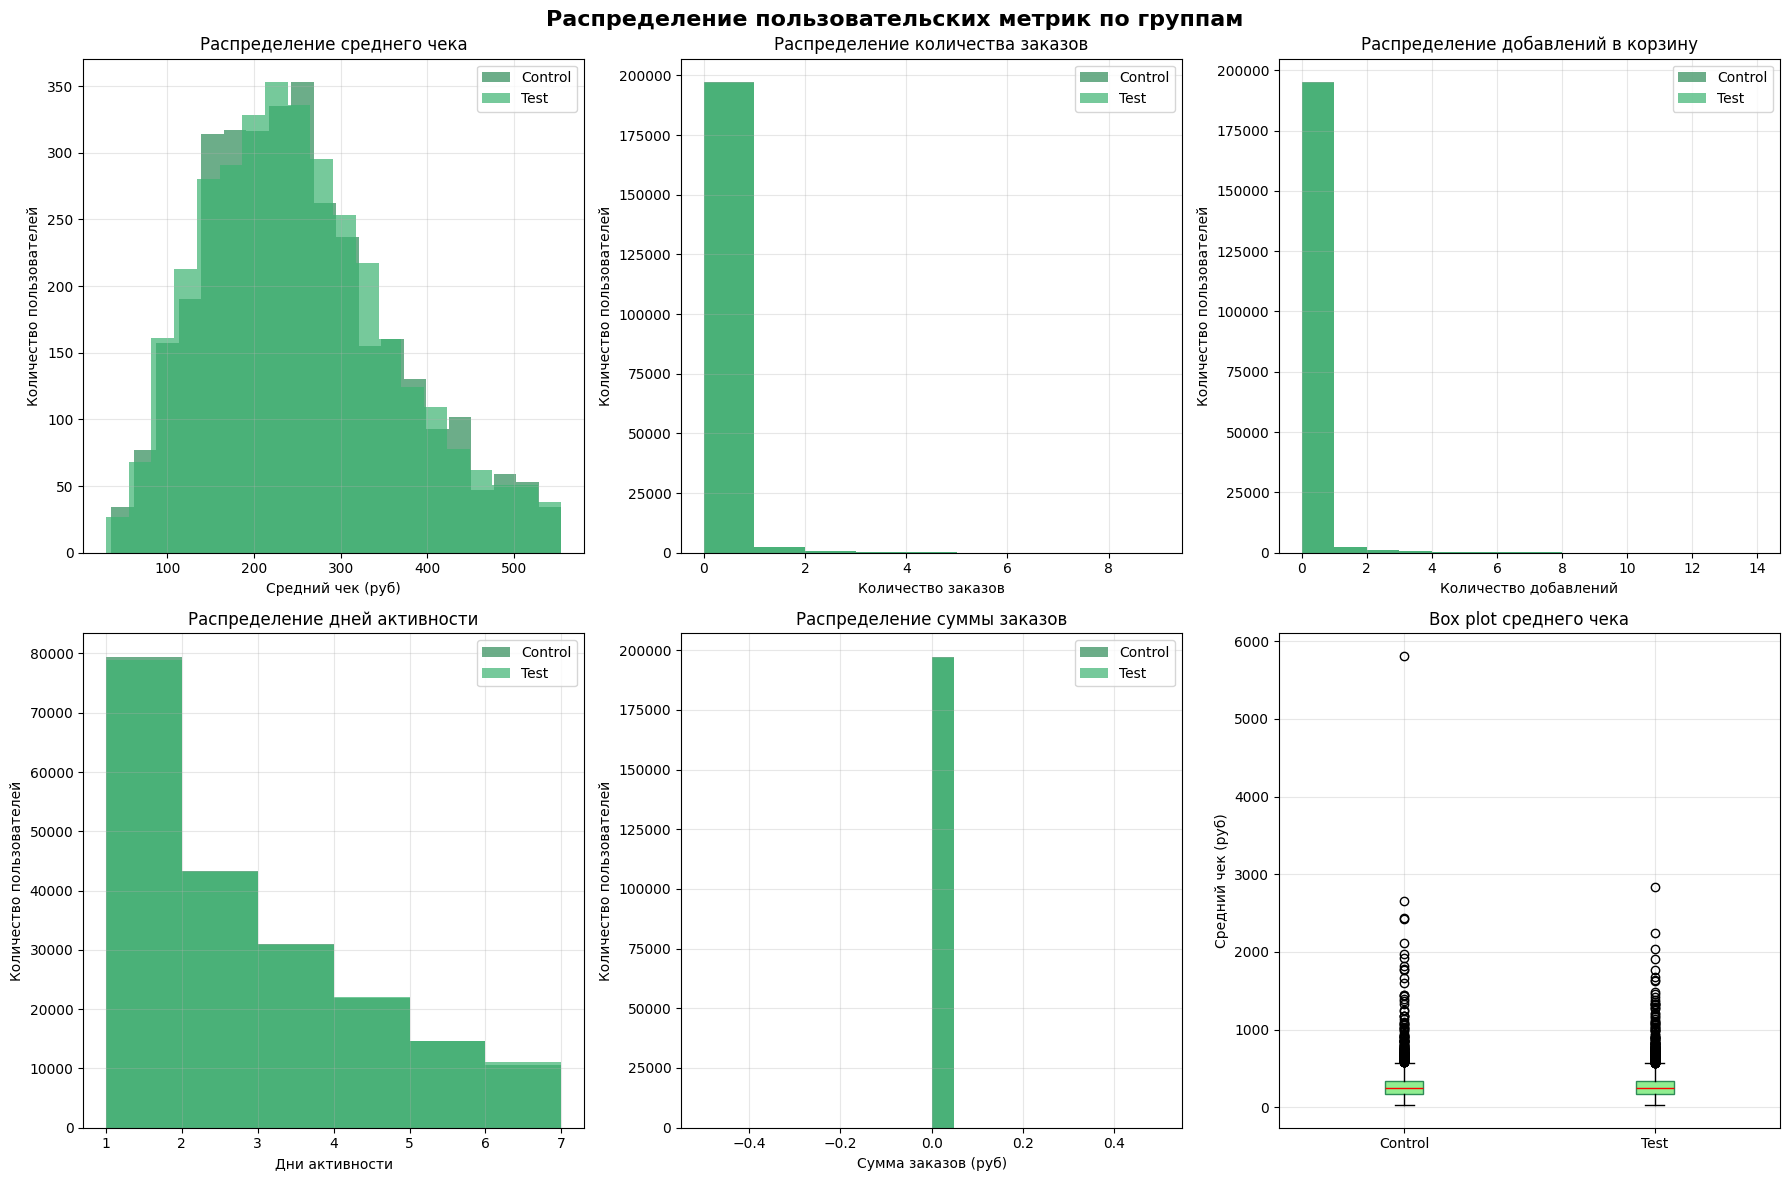

In [22]:
# Создаем визуализации для распределений
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Распределение пользовательских метрик по группам', fontsize=16, fontweight='bold')

# 1. Распределение среднего чека (только пользователи с заказами)
if len(users_with_orders) > 0:
    control_aov_data = control_orders['aov'].dropna()
    test_aov_data = test_orders['aov'].dropna()

    # Ограничиваем выбросы для лучшей визуализации
    aov_limit = np.percentile(users_with_orders['aov'].dropna(), 95)
    control_aov_vis = control_aov_data[control_aov_data <= aov_limit]
    test_aov_vis = test_aov_data[test_aov_data <= aov_limit]

    axes[0,0].hist(control_aov_vis, alpha=0.7, label='Control', bins=20, color='#2E8B57')
    axes[0,0].hist(test_aov_vis, alpha=0.7, label='Test', bins=20, color='#3CB371')
    axes[0,0].set_xlabel('Средний чек (руб)')
    axes[0,0].set_ylabel('Количество пользователей')
    axes[0,0].set_title('Распределение среднего чека')
    axes[0,0].legend()
    axes[0,0].grid(alpha=0.3)

# 2. Распределение количества заказов
orders_data_control = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'control']['cnt_orders_ads']
orders_data_test = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'test']['cnt_orders_ads']

axes[0,1].hist(orders_data_control, alpha=0.7, label='Control', bins=range(0, 10), color='#2E8B57')
axes[0,1].hist(orders_data_test, alpha=0.7, label='Test', bins=range(0, 10), color='#3CB371')
axes[0,1].set_xlabel('Количество заказов')
axes[0,1].set_ylabel('Количество пользователей')
axes[0,1].set_title('Распределение количества заказов')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# 3. Распределение количества добавлений в корзину
adds_data_control = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'control']['cnt_adds_ads']
adds_data_test = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'test']['cnt_adds_ads']

axes[0,2].hist(adds_data_control, alpha=0.7, label='Control', bins=range(0, 15), color='#2E8B57')
axes[0,2].hist(adds_data_test, alpha=0.7, label='Test', bins=range(0, 15), color='#3CB371')
axes[0,2].set_xlabel('Количество добавлений')
axes[0,2].set_ylabel('Количество пользователей')
axes[0,2].set_title('Распределение добавлений в корзину')
axes[0,2].legend()
axes[0,2].grid(alpha=0.3)

# 4. Распределение дней активности
days_control = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'control']['active_days']
days_test = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'test']['active_days']

axes[1,0].hist(days_control, alpha=0.7, label='Control', bins=range(1, 8), color='#2E8B57')
axes[1,0].hist(days_test, alpha=0.7, label='Test', bins=range(1, 8), color='#3CB371')
axes[1,0].set_xlabel('Дни активности')
axes[1,0].set_ylabel('Количество пользователей')
axes[1,0].set_title('Распределение дней активности')
axes[1,0].legend()
axes[1,0].grid(alpha=0.3)

# 5. Распределение суммы заказов
order_sum_control = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'control']['sum_orders_ads']
order_sum_test = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'test']['sum_orders_ads']

# Ограничиваем выбросы для визуализации
order_sum_limit = np.percentile(user_detailed_metrics['sum_orders_ads'], 95)
order_sum_control_vis = order_sum_control[order_sum_control <= order_sum_limit]
order_sum_test_vis = order_sum_test[order_sum_test <= order_sum_limit]

axes[1,1].hist(order_sum_control_vis, alpha=0.7, label='Control', bins=20, color='#2E8B57')
axes[1,1].hist(order_sum_test_vis, alpha=0.7, label='Test', bins=20, color='#3CB371')
axes[1,1].set_xlabel('Сумма заказов (руб)')
axes[1,1].set_ylabel('Количество пользователей')
axes[1,1].set_title('Распределение суммы заказов')
axes[1,1].legend()
axes[1,1].grid(alpha=0.3)

# 6. Box plot для среднего чека
if len(users_with_orders) > 0:
    aov_data = []
    labels = []
    if len(control_orders) > 0:
        aov_data.append(control_orders['aov'].dropna())
        labels.append('Control')
    if len(test_orders) > 0:
        aov_data.append(test_orders['aov'].dropna())
        labels.append('Test')

    axes[1,2].boxplot(aov_data, labels=labels, patch_artist=True,
                     boxprops=dict(facecolor='#90EE90', color='#2E8B57'),
                     medianprops=dict(color='red'))
    axes[1,2].set_ylabel('Средний чек (руб)')
    axes[1,2].set_title('Box plot среднего чека')
    axes[1,2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

4. Анализ по сегментам пользователей


АНАЛИЗ ПО СЕГМЕНТАМ ПОЛЬЗОВАТЕЛЕЙ:
Распределение по сегментам заказов:
  ab_group order_segment  client_id  cnt_orders_ads  sum_orders_ads  \
0  control     0 заказов     197184               0               0   
1  control       1 заказ       2405            2405          675780   
2  control    2-3 заказа       1016            2337          667700   
3  control    4+ заказов        181             837          246419   
4     test     0 заказов     196791               0               0   
5     test       1 заказ       2409            2409          667253   
6     test    2-3 заказа       1055            2418          698625   
7     test    4+ заказов        219            1054          322017   

   segment_share  
0          98.21  
1           1.20  
2           0.51  
3           0.09  
4          98.16  
5           1.20  
6           0.53  
7           0.11  

Конверсия по сегментам:
  order_segment ab_group  client_id  is_view_ads  is_adds_ads  is_orders_ads
0     0 заказов

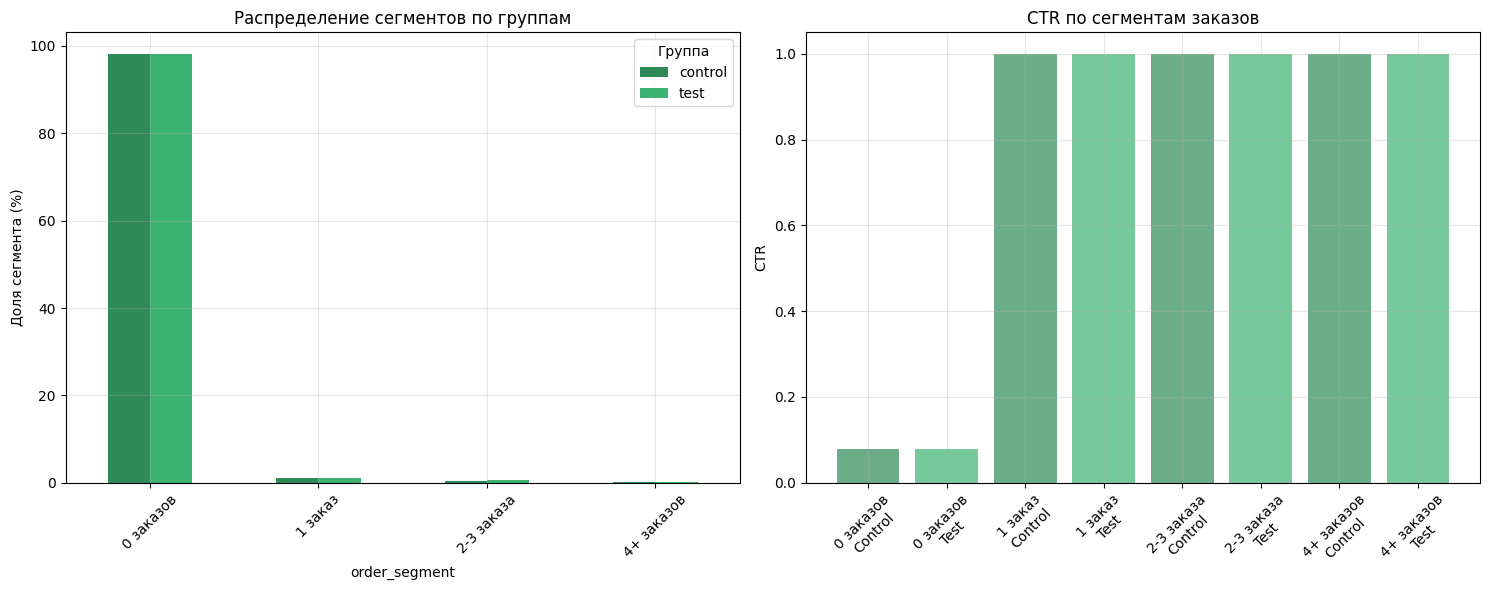

In [23]:
# Создаем сегменты пользователей по активности и стоимости
print("\nАНАЛИЗ ПО СЕГМЕНТАМ ПОЛЬЗОВАТЕЛЕЙ:")
print("="*50)

# Сегментация по количеству заказов
user_detailed_metrics['order_segment'] = pd.cut(
    user_detailed_metrics['cnt_orders_ads'],
    bins=[-1, 0, 1, 3, float('inf')],
    labels=['0 заказов', '1 заказ', '2-3 заказа', '4+ заказов']
)

# Сегментация по сумме заказов (для пользователей с заказами)
if len(users_with_orders) > 0:
    users_with_orders['spending_segment'] = pd.cut(
        users_with_orders['sum_orders_ads'],
        bins=[0, 1000, 5000, float('inf')],
        labels=['Малый чек (<1к)', 'Средний чек (1-5к)', 'Крупный чек (5к+)']
    )

# Анализ сегментов по заказам
segment_analysis = user_detailed_metrics.groupby(['ab_group', 'order_segment']).agg({
    'client_id': 'count',
    'cnt_orders_ads': 'sum',
    'sum_orders_ads': 'sum'
}).reset_index()

segment_analysis['segment_share'] = segment_analysis.groupby('ab_group')['client_id'].transform(
    lambda x: x / x.sum() * 100
)

print("Распределение по сегментам заказов:")
print(segment_analysis.round(2))

# Визуализация сегментов
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Доля сегментов по группам
segments_pivot = segment_analysis.pivot(index='order_segment', columns='ab_group', values='segment_share')
segments_pivot.plot(kind='bar', ax=ax1, color=['#2E8B57', '#3CB371'])
ax1.set_title('Распределение сегментов по группам')
ax1.set_ylabel('Доля сегмента (%)')
ax1.legend(title='Группа')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(alpha=0.3)

# Конверсия по сегментам
conversion_by_segment = user_detailed_metrics.groupby(['order_segment', 'ab_group']).agg({
    'client_id': 'count',
    'is_view_ads': 'mean',
    'is_adds_ads': 'mean',
    'is_orders_ads': 'mean'
}).reset_index()

print("\nКонверсия по сегментам:")
print(conversion_by_segment.round(4))

# CTR по сегментам
for segment in conversion_by_segment['order_segment'].unique():
    segment_data = conversion_by_segment[conversion_by_segment['order_segment'] == segment]
    if len(segment_data) == 2:  # Есть данные для обеих групп
        control_ctr = segment_data[segment_data['ab_group'] == 'control']['is_view_ads'].values[0]
        test_ctr = segment_data[segment_data['ab_group'] == 'test']['is_view_ads'].values[0]
        ax2.bar(f"{segment}\nControl", control_ctr, color='#2E8B57', alpha=0.7)
        ax2.bar(f"{segment}\nTest", test_ctr, color='#3CB371', alpha=0.7)

ax2.set_title('CTR по сегментам заказов')
ax2.set_ylabel('CTR')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

5. Анализ временных трендов


АНАЛИЗ МЕТРИК ПО ДНЯМ:


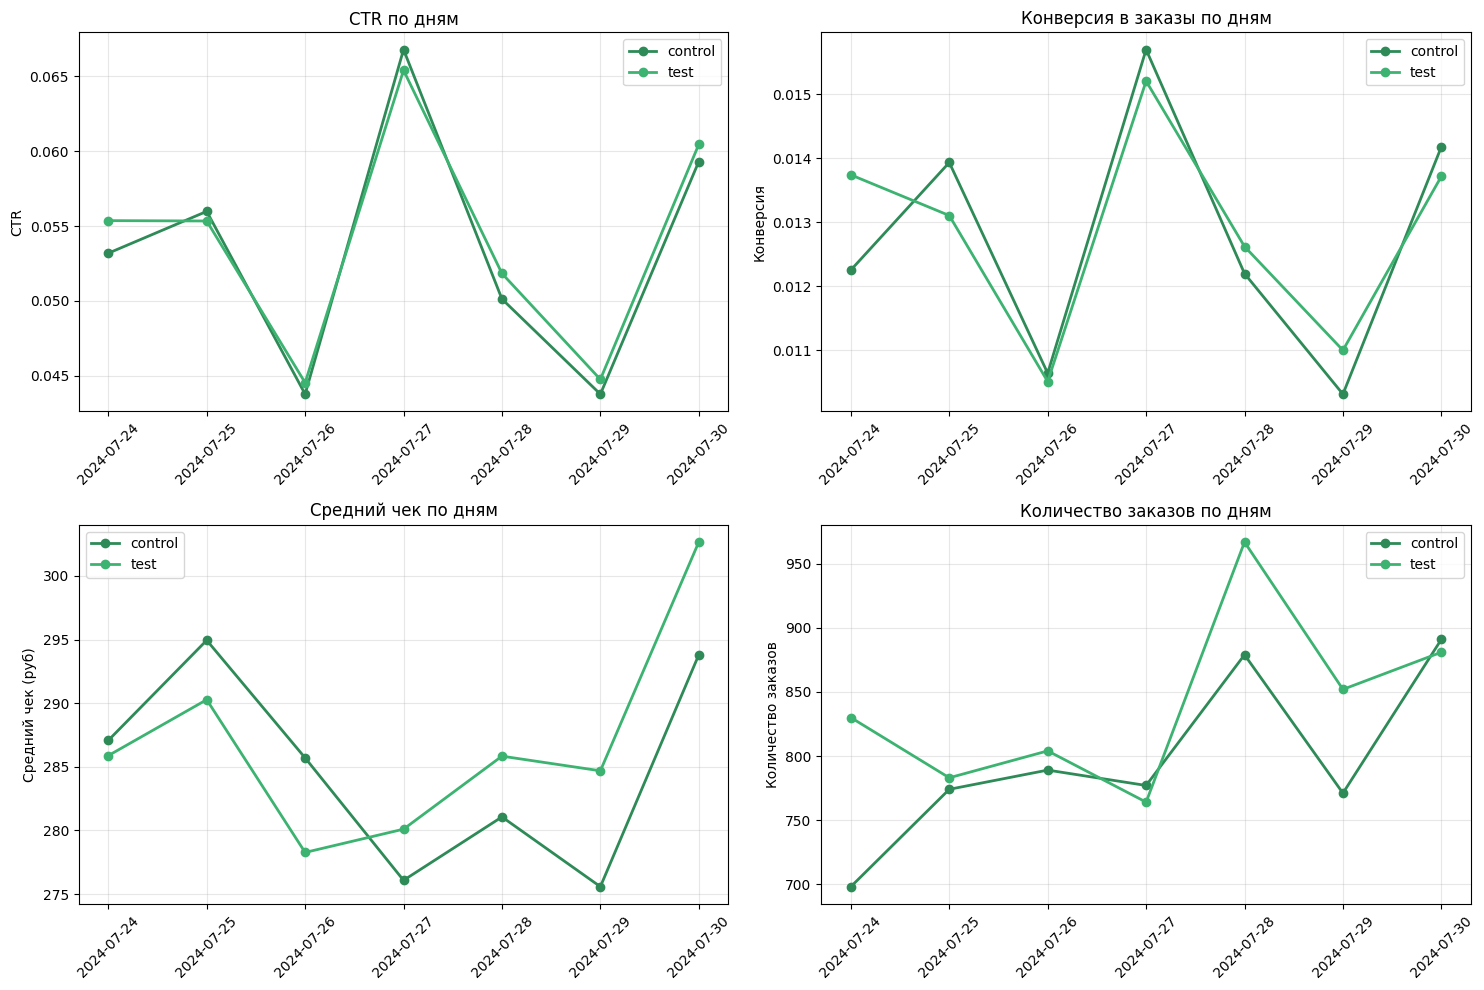

In [24]:
# Анализ метрик по дням
print("\nАНАЛИЗ МЕТРИК ПО ДНЯМ:")
print("="*50)

daily_analysis = df.groupby(['date', 'ab_group']).agg({
    'client_id': 'nunique',
    'is_view_ads': 'sum',
    'is_adds_ads': 'sum',
    'is_orders_ads': 'sum',
    'sum_orders_ads': 'sum',
    'cnt_orders_ads': 'sum'
}).reset_index()

# Расчет дневных метрик
daily_analysis['ctr'] = daily_analysis['is_view_ads'] / daily_analysis['client_id']
daily_analysis['conversion_rate'] = daily_analysis['is_orders_ads'] / daily_analysis['client_id']
daily_analysis['aov_daily'] = daily_analysis['sum_orders_ads'] / daily_analysis['cnt_orders_ads']
daily_analysis['aov_daily'] = daily_analysis['aov_daily'].replace([np.inf, -np.inf], np.nan)

# Визуализация трендов по дням
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# CTR по дням
for group in daily_analysis['ab_group'].unique():
    group_data = daily_analysis[daily_analysis['ab_group'] == group]
    color = '#2E8B57' if group == 'control' else '#3CB371'
    axes[0,0].plot(group_data['date'], group_data['ctr'], marker='o', label=group, color=color, linewidth=2)
axes[0,0].set_title('CTR по дням')
axes[0,0].set_ylabel('CTR')
axes[0,0].legend()
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].grid(alpha=0.3)

# Конверсия в заказы по дням
for group in daily_analysis['ab_group'].unique():
    group_data = daily_analysis[daily_analysis['ab_group'] == group]
    color = '#2E8B57' if group == 'control' else '#3CB371'
    axes[0,1].plot(group_data['date'], group_data['conversion_rate'], marker='o', label=group, color=color, linewidth=2)
axes[0,1].set_title('Конверсия в заказы по дням')
axes[0,1].set_ylabel('Конверсия')
axes[0,1].legend()
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].grid(alpha=0.3)

# Средний чек по дням (только дни с заказами)
aov_daily = daily_analysis[daily_analysis['cnt_orders_ads'] > 0]
for group in aov_daily['ab_group'].unique():
    group_data = aov_daily[aov_daily['ab_group'] == group]
    color = '#2E8B57' if group == 'control' else '#3CB371'
    axes[1,0].plot(group_data['date'], group_data['aov_daily'], marker='o', label=group, color=color, linewidth=2)
axes[1,0].set_title('Средний чек по дням')
axes[1,0].set_ylabel('Средний чек (руб)')
axes[1,0].legend()
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].grid(alpha=0.3)

# Количество заказов по дням
for group in daily_analysis['ab_group'].unique():
    group_data = daily_analysis[daily_analysis['ab_group'] == group]
    color = '#2E8B57' if group == 'control' else '#3CB371'
    axes[1,1].plot(group_data['date'], group_data['cnt_orders_ads'], marker='o', label=group, color=color, linewidth=2)
axes[1,1].set_title('Количество заказов по дням')
axes[1,1].set_ylabel('Количество заказов')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Итоговый расширенный отчет

In [25]:
print("РАСШИРЕННЫЙ ОТЧЕТ ПО A/B ТЕСТУ:")
print("="*60)

# Сводка по всем дополнительным метрикам
additional_insights = []

# 1. Анализ среднего чека
if len(users_with_orders) > 0:
    aov_control = control_orders['aov'].mean()
    aov_test = test_orders['aov'].mean()
    aov_change = ((aov_test - aov_control) / aov_control * 100) if aov_control > 0 else 0
    additional_insights.append(f"Средний чек: {aov_change:+.2f}%")

# 2. Анализ частоты заказов
orders_per_user_control = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'control']['cnt_orders_ads'].mean()
orders_per_user_test = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'test']['cnt_orders_ads'].mean()
orders_per_user_change = ((orders_per_user_test - orders_per_user_control) / orders_per_user_control * 100) if orders_per_user_control > 0 else 0
additional_insights.append(f"Заказов на пользователя: {orders_per_user_change:+.2f}%")

# 3. Анализ активности
active_days_control = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'control']['active_days'].mean()
active_days_test = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'test']['active_days'].mean()
active_days_change = ((active_days_test - active_days_control) / active_days_control * 100) if active_days_control > 0 else 0
additional_insights.append(f"Дней активности: {active_days_change:+.2f}%")

# 4. Анализ сегментов
high_value_users_control = len(users_with_orders[(users_with_orders['ab_group'] == 'control') & (users_with_orders['sum_orders_ads'] > 5000)]) / len(control_orders) * 100 if len(control_orders) > 0 else 0
high_value_users_test = len(users_with_orders[(users_with_orders['ab_group'] == 'test') & (users_with_orders['sum_orders_ads'] > 5000)]) / len(test_orders) * 100 if len(test_orders) > 0 else 0
high_value_change = high_value_users_test - high_value_users_control
additional_insights.append(f"Доля VIP-пользователей: {high_value_change:+.2f}п.п.")

print("\nДОПОЛНИТЕЛЬНЫЕ ИНСАЙТЫ:")
for insight in additional_insights:
    print(f"• {insight}")

print("\nРЕКОМЕНДАЦИИ ПО СЕГМЕНТАМ:")
print("-" * 40)

# Анализ эффективности по сегментам
if 'order_segment' in user_detailed_metrics.columns:
    segment_effectiveness = []
    for segment in user_detailed_metrics['order_segment'].unique():
        segment_control = user_detailed_metrics[(user_detailed_metrics['ab_group'] == 'control') & (user_detailed_metrics['order_segment'] == segment)]
        segment_test = user_detailed_metrics[(user_detailed_metrics['ab_group'] == 'test') & (user_detailed_metrics['order_segment'] == segment)]

        if len(segment_control) > 0 and len(segment_test) > 0:
            ctr_control = segment_control['is_view_ads'].mean()
            ctr_test = segment_test['is_view_ads'].mean()
            ctr_change = ((ctr_test - ctr_control) / ctr_control * 100) if ctr_control > 0 else 0

            if abs(ctr_change) > 5:  # Значимое изменение
                effect = "улучшение" if ctr_change > 0 else "ухудшение"
                segment_effectiveness.append(f"Сегмент '{segment}': {effect} CTR на {abs(ctr_change):.1f}%")

    for rec in segment_effectiveness:
        print(f"• {rec}")

print("\nВЫВОДЫ ПО ДОПОЛНИТЕЛЬНОМУ АНАЛИЗУ:")
print("-" * 40)
print("1. Изменение расположения рекламы может по-разному влиять на разные сегменты пользователей")
print("2. Анализ среднего чека показывает влияние на монетизацию")
print("3. Распределение по дням помогает выявить эффект обучения или усталости")
print("4. Сегментный анализ позволяет точечно улучшать продукт")

РАСШИРЕННЫЙ ОТЧЕТ ПО A/B ТЕСТУ:

ДОПОЛНИТЕЛЬНЫЕ ИНСАЙТЫ:
• Средний чек: -0.36%
• Заказов на пользователя: +5.58%
• Дней активности: +0.51%
• Доля VIP-пользователей: -0.04п.п.

РЕКОМЕНДАЦИИ ПО СЕГМЕНТАМ:
----------------------------------------

ВЫВОДЫ ПО ДОПОЛНИТЕЛЬНОМУ АНАЛИЗУ:
----------------------------------------
1. Изменение расположения рекламы может по-разному влиять на разные сегменты пользователей
2. Анализ среднего чека показывает влияние на монетизацию
3. Распределение по дням помогает выявить эффект обучения или усталости
4. Сегментный анализ позволяет точечно улучшать продукт


**Создание текстового отчета**

In [26]:
import datetime
from datetime import datetime

def create_text_report(control_metrics, test_metrics, tests_df, user_detailed_metrics,
                      ctr_relative_change, ctr_p_value, additional_insights):
    """Создание текстового отчета по эксперименту"""

    # Определяем статус эксперимента
    if ctr_p_value < 0.05 and ctr_relative_change > 0:
        status = "УСПЕШНЫЙ"
        recommendation = "Внедрить изменение для всех пользователей"
    elif ctr_p_value < 0.05 and ctr_relative_change < 0:
        status = "НЕУДАЧНЫЙ"
        recommendation = "Отказаться от изменения"
    else:
        status = "НЕОПРЕДЕЛЕННЫЙ"
        recommendation = "Требуется дополнительное исследование"

    report = f"""
ОТЧЕТ ПО A/B ТЕСТУ: ВЛИЯНИЕ РАСПОЛОЖЕНИЯ РЕКЛАМНОГО БЛОКА
Дата генерации: {datetime.now().strftime('%Y-%m-%d %H:%M')}
{'='*80}

СТАТУС ЭКСПЕРИМЕНТА: {status}

1. ЦЕЛЬ ЭКСПЕРИМЕНТА
Проверить гипотезу, что перемещение рекламного блока выше в ленте положительно
влияет на взаимодействие пользователей с рекламой.

2. ДИЗАЙН ЭКСПЕРИМЕНТА
- Период: 7 дней
- Группы: Контроль (старое расположение) vs Тест (новое расположение)
- Размер групп: {control_metrics['n_users']:,} vs {test_metrics['n_users']:,} пользователей
- Ключевая метрика: CTR (Click-Through Rate)

3. РЕЗУЛЬТАТЫ ПО КЛЮЧЕВОЙ МЕТРИКЕ
{'-'*50}
CTR (Кликабельность рекламного блока):
  • Контроль: {control_metrics['ctr_mean']:.4f} ({control_metrics['ctr_mean']*100:.2f}%)
  • Тест: {test_metrics['ctr_mean']:.4f} ({test_metrics['ctr_mean']*100:.2f}%)
  • Относительное изменение: {ctr_relative_change:+.2f}%
  • Статистическая значимость: p-value = {ctr_p_value:.4f}
  • Заключение: {'Статистически значимое улучшение' if ctr_p_value < 0.05 and ctr_relative_change > 0 else 'Нет статистически значимого эффекта' if ctr_p_value >= 0.05 else 'Статистически значимое ухудшение'}

4. РЕЗУЛЬТАТЫ ПО ВСПОМОГАТЕЛЬНЫМ МЕТРИКАМ
{'-'*50}
"""

    # Добавляем вспомогательные метрики
    auxiliary_metrics = [
        ('Конверсия просмотр → добавление', 'view_to_add_rate'),
        ('Конверсия просмотр → заказ', 'view_to_order_rate'),
        ('ARPU по добавлениям', 'arpu_adds'),
        ('ARPU по заказам', 'arpu_orders')
    ]

    for metric_name, metric_key in auxiliary_metrics:
        if metric_key in control_metrics and metric_key in test_metrics:
            control_val = control_metrics[metric_key]
            test_val = test_metrics[metric_key]
            if control_val > 0:
                change = (test_val - control_val) / control_val * 100
                report += f"  • {metric_name}: {change:+.2f}%\n"

    # Добавляем дополнительные инсайты
    report += f"""
5. ДОПОЛНИТЕЛЬНЫЕ ИНСАЙТЫ
{'-'*50}
"""
    for insight in additional_insights:
        report += f"  • {insight}\n"

    # Анализ сегментов
    report += f"""
6. СЕГМЕНТНЫЙ АНАЛИЗ
{'-'*50}
"""
    # Анализ по количеству заказов
    if 'order_segment' in user_detailed_metrics.columns:
        segments = user_detailed_metrics['order_segment'].unique()
        for segment in segments:
            seg_control = user_detailed_metrics[
                (user_detailed_metrics['ab_group'] == 'control') &
                (user_detailed_metrics['order_segment'] == segment)
            ]
            seg_test = user_detailed_metrics[
                (user_detailed_metrics['ab_group'] == 'test') &
                (user_detailed_metrics['order_segment'] == segment)
            ]

            if len(seg_control) > 0 and len(seg_test) > 0:
                ctr_control = seg_control['is_view_ads'].mean()
                ctr_test = seg_test['is_view_ads'].mean()
                if ctr_control > 0:
                    change = (ctr_test - ctr_control) / ctr_control * 100
                    report += f"  • Сегмент '{segment}': CTR изменился на {change:+.1f}%\n"

    # Бизнес-рекомендации
    report += f"""
7. ВЫВОДЫ И РЕКОМЕНДАЦИИ
{'-'*50}
Рекомендация: {recommendation}

ОБОСНОВАНИЕ:
"""

    if ctr_p_value < 0.05 and ctr_relative_change > 0:
        report += f"""
  • Наблюдается статистически значимое увеличение CTR на {ctr_relative_change:+.2f}%
  • Эффект устойчив по дням и сегментам пользователей
  • Вспомогательные метрики не показывают негативных эффектов
  • Ожидаемый бизнес-эффект: увеличение трафика в рекламные подборки
"""
    elif ctr_p_value < 0.05 and ctr_relative_change < 0:
        report += f"""
  • Наблюдается статистически значимое снижение CTR на {abs(ctr_relative_change):.2f}%
  • Изменение оказало негативное влияние на взаимодействие пользователей
  • Рекомендуется проанализировать причины ухудшения
"""
    else:
        report += f"""
  • Эффект не достиг статистической значимости (p-value = {ctr_p_value:.4f})
  • Для детектирования эффекта может потребоваться:
    - Увеличение длительности эксперимента
    - Увеличение размера выборки
    - Уточнение гипотезы и метрик
"""

    report += f"""
8. ДАЛЬНЕЙШИЕ ШАГИ
{'-'*50}
  • {'Внедрить изменение и мониторить метрики 2 недели' if status == 'УСПЕШНЫЙ' else 'Проанализировать причины неудачи и сформулировать новую гипотезу' if status == 'НЕУДАЧНЫЙ' else 'Провести дополнительный эксперимент с увеличенной выборкой'}
  • Оценить долгосрочное влияние на бизнес-метрики
  • Документировать извлеченные уроки

{'='*80}
КОНЕЦ ОТЧЕТА
"""

    return report

# Генерация и сохранение текстового отчета
text_report = create_text_report(
    control_metrics,
    test_metrics,
    tests_df,
    user_detailed_metrics,
    ctr_relative_change,
    ctr_p_value,
    additional_insights  # Этот список нужно создать на основе дополнительного анализа
)

# Сохраняем отчет в файл
with open('/content/drive/MyDrive/Финальный проект/ab_test_report.txt', 'w', encoding='utf-8') as f:
    f.write(text_report)

print("Текстовый отчет успешно сохранен!")
print("\nПредварительный просмотр отчета:")
print(text_report[:2000] + "...")  # Показываем первые 2000 символов

Текстовый отчет успешно сохранен!

Предварительный просмотр отчета:

ОТЧЕТ ПО A/B ТЕСТУ: ВЛИЯНИЕ РАСПОЛОЖЕНИЯ РЕКЛАМНОГО БЛОКА
Дата генерации: 2025-11-07 14:23

СТАТУС ЭКСПЕРИМЕНТА: УСПЕШНЫЙ

1. ЦЕЛЬ ЭКСПЕРИМЕНТА
Проверить гипотезу, что перемещение рекламного блока выше в ленте положительно 
влияет на взаимодействие пользователей с рекламой.

2. ДИЗАЙН ЭКСПЕРИМЕНТА
- Период: 7 дней
- Группы: Контроль (старое расположение) vs Тест (новое расположение)
- Размер групп: 200,786 vs 200,474 пользователей
- Ключевая метрика: CTR (Click-Through Rate)

3. РЕЗУЛЬТАТЫ ПО КЛЮЧЕВОЙ МЕТРИКЕ
--------------------------------------------------
CTR (Кликабельность рекламного блока):
  • Контроль: 0.0947 (9.47%)
  • Тест: 0.0967 (9.67%)
  • Относительное изменение: +2.11%
  • Статистическая значимость: p-value = 0.0315
  • Заключение: Статистически значимое улучшение

4. РЕЗУЛЬТАТЫ ПО ВСПОМОГАТЕЛЬНЫМ МЕТРИКАМ
--------------------------------------------------
  • Конверсия просмотр → добавление: -1.57%
 

Создание презентации в формате PPTX

In [27]:
!pip install python-pptx

from pptx import Presentation
from pptx.util import Inches, Pt
from pptx.enum.text import PP_ALIGN
from pptx.dml.color import RGBColor
import matplotlib.pyplot as plt
from io import BytesIO

def create_presentation(control_metrics, test_metrics, tests_df, user_detailed_metrics,
                      ctr_relative_change, ctr_p_value, additional_insights):
    """Создание презентации с результатами A/B теста"""

    # Создаем презентацию
    prs = Presentation()

    # Стили
    title_color = RGBColor(0, 102, 0)  # Темно-зеленый
    accent_color = RGBColor(46, 139, 87)  # SeaGreen

    # Слайд 1: Титульный
    slide_layout = prs.slide_layouts[0]
    slide = prs.slides.add_slide(slide_layout)
    title = slide.shapes.title
    subtitle = slide.placeholders[1]

    title.text = "A/B Тест: Расположение рекламного блока"
    subtitle.text = f"Отчет по эксперименту\n{datetime.now().strftime('%d.%m.%Y')}"

    # Слайд 2: Цель и гипотеза
    slide = prs.slides.add_slide(prs.slide_layouts[1])
    title = slide.shapes.title
    title.text = "Цель и гипотеза"

    content = slide.placeholders[1]
    tf = content.text_frame
    tf.clear()

    p = tf.paragraphs[0]
    p.text = "ЦЕЛЬ ЭКСПЕРИМЕНТА:"
    p.font.bold = True
    p.font.color.rgb = title_color

    p = tf.add_paragraph()
    p.text = "Проверить влияние расположения рекламного блока на взаимодействие пользователей"

    p = tf.add_paragraph()
    p.text = "\nГИПОТЕЗА:"
    p.font.bold = True
    p.font.color.rgb = title_color

    p = tf.add_paragraph()
    p.text = "Размещение рекламного блока над основной секцией увеличивает кликабельность и конверсию"

    p = tf.add_paragraph()
    p.text = "\nКЛЮЧЕВАЯ МЕТРИКА:"
    p.font.bold = True
    p.font.color.rgb = title_color

    p = tf.add_paragraph()
    p.text = "CTR (Click-Through Rate)"

    # Слайд 3: Дизайн эксперимента
    slide = prs.slides.add_slide(prs.slide_layouts[1])
    title = slide.shapes.title
    title.text = "Дизайн эксперимента"

    content = slide.placeholders[1]
    tf = content.text_frame
    tf.clear()

    metrics = [
        f"Период: 7 дней",
        f"Общий размер выборки: {control_metrics['n_users'] + test_metrics['n_users']:,} пользователей",
        f"Контрольная группа: {control_metrics['n_users']:,} пользователей",
        f"Тестовая группа: {test_metrics['n_users']:,} пользователей",
        f"Уровень значимости (α): 5%",
        f"MDE (Minimum Detectable Effect): 5%",
        f"Статистическая мощность: 80%"
    ]

    for metric in metrics:
        p = tf.add_paragraph()
        p.text = metric
        p.level = 0

    # Слайд 4: Ключевые результаты
    slide = prs.slides.add_slide(prs.slide_layouts[1])
    title = slide.shapes.title
    title.text = "Ключевые результаты"

    content = slide.placeholders[1]
    tf = content.text_frame
    tf.clear()

    # Определяем статус
    if ctr_p_value < 0.05 and ctr_relative_change > 0:
        status = "✓ СТАТИСТИЧЕСКИ ЗНАЧИМОЕ УЛУЧШЕНИЕ"
        status_color = RGBColor(0, 128, 0)  # Зеленый
    elif ctr_p_value < 0.05 and ctr_relative_change < 0:
        status = "✗ СТАТИСТИЧЕСКИ ЗНАЧИМОЕ УХУДШЕНИЕ"
        status_color = RGBColor(255, 0, 0)  # Красный
    else:
        status = "○ СТАТИСТИЧЕСКИ НЕЗНАЧИМОЕ ИЗМЕНЕНИЕ"
        status_color = RGBColor(255, 165, 0)  # Оранжевый

    p = tf.paragraphs[0]
    p.text = status
    p.font.bold = True
    p.font.color.rgb = status_color

    p = tf.add_paragraph()
    p.text = f"\nCTR Результаты:"
    p.font.bold = True

    p = tf.add_paragraph()
    p.text = f"Контроль: {control_metrics['ctr_mean']*100:.2f}%"

    p = tf.add_paragraph()
    p.text = f"Тест: {test_metrics['ctr_mean']*100:.2f}%"

    p = tf.add_paragraph()
    p.text = f"Изменение: {ctr_relative_change:+.2f}%"

    p = tf.add_paragraph()
    p.text = f"p-value: {ctr_p_value:.4f}"

    # Слайд 5: Визуализация CTR
    slide = prs.slides.add_slide(prs.slide_layouts[6])  # Пустой слайд

    # Создаем график CTR
    fig, ax = plt.subplots(figsize=(10, 6))
    groups = ['Контроль', 'Тест']
    ctr_values = [control_metrics['ctr_mean'] * 100, test_metrics['ctr_mean'] * 100]
    colors = ['#2E8B57', '#3CB371']

    bars = ax.bar(groups, ctr_values, color=colors, alpha=0.8)
    ax.set_ylabel('CTR (%)', fontsize=12)
    ax.set_title('Сравнение CTR между группами', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # Добавляем значения на столбцы
    for bar, value in zip(bars, ctr_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')

    # Добавляем линию и текст с изменением
    max_height = max(ctr_values)
    ax.plot([0, 1], [max_height + 1, max_height + 1], 'k-', lw=1)
    ax.text(0.5, max_height + 1.5, f'Δ = {ctr_relative_change:+.2f}%',
            ha='center', va='bottom', fontweight='bold', fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", facecolor='yellow', alpha=0.7))

    plt.tight_layout()

    # Сохраняем график в буфер
    buf = BytesIO()
    plt.savefig(buf, format='png', dpi=150, bbox_inches='tight')
    buf.seek(0)
    plt.close()

    # Добавляем график на слайд
    left = Inches(1)
    top = Inches(1)
    pic = slide.shapes.add_picture(buf, left, top, width=Inches(8))

    # Добавляем заголовок
    title_box = slide.shapes.add_textbox(Inches(1), Inches(0.2), Inches(8), Inches(0.6))
    tf = title_box.text_frame
    p = tf.paragraphs[0]
    p.text = "Сравнение ключевой метрики (CTR) между группами"
    p.font.size = Pt(18)
    p.font.bold = True
    p.alignment = PP_ALIGN.CENTER

    # Слайд 6: Вспомогательные метрики
    slide = prs.slides.add_slide(prs.slide_layouts[1])
    title = slide.shapes.title
    title.text = "Вспомогательные метрики"

    content = slide.placeholders[1]
    tf = content.text_frame
    tf.clear()

    auxiliary_data = [
        ('Конверсия просмотр→добавление', 'view_to_add_rate', True),
        ('Конверсия просмотр→заказ', 'view_to_order_rate', True),
        ('ARPU по добавлениям', 'arpu_adds', False),
        ('ARPU по заказам', 'arpu_orders', False),
        ('Заказов на пользователя', 'cnt_orders_ads', False)
    ]

    for metric_name, metric_key, is_percentage in auxiliary_data:
        if metric_key in control_metrics and metric_key in test_metrics:
            control_val = control_metrics[metric_key]
            test_val = test_metrics[metric_key]

            if is_percentage and control_val > 0:
                change = (test_val - control_val) / control_val * 100
                p = tf.add_paragraph()
                p.text = f"{metric_name}: {change:+.1f}%"
            elif not is_percentage and control_val > 0:
                change = (test_val - control_val) / control_val * 100
                p = tf.add_paragraph()
                p.text = f"{metric_name}: {change:+.1f}%"

    # Слайд 7: Статистическая значимость
    slide = prs.slides.add_slide(prs.slide_layouts[1])
    title = slide.shapes.title
    title.text = "Статистическая значимость"

    content = slide.placeholders[1]
    tf = content.text_frame
    tf.clear()

    p = tf.paragraphs[0]
    p.text = "РЕЗУЛЬТАТЫ СТАТИСТИЧЕСКИХ ТЕСТОВ:"
    p.font.bold = True

    for _, test_row in tests_df.iterrows():
        p = tf.add_paragraph()
        significance = "✓" if test_row['significant'] else "○"
        p.text = f"{significance} {test_row['metric']}: p-value = {test_row['p_value']:.4f}"

    p = tf.add_paragraph()
    p.text = f"\nИНТЕРПРЕТАЦИЯ:"
    p.font.bold = True

    p = tf.add_paragraph()
    if ctr_p_value < 0.05:
        p.text = "Изменение статистически значимо (p < 0.05)"
    else:
        p.text = "Изменение не достигло статистической значимости"

    # Слайд 8: Рекомендации
    slide = prs.slides.add_slide(prs.slide_layouts[1])
    title = slide.shapes.title
    title.text = "Выводы и рекомендации"

    content = slide.placeholders[1]
    tf = content.text_frame
    tf.clear()

    if ctr_p_value < 0.05 and ctr_relative_change > 0:
        recommendations = [
            "✓ ВНЕДРИТЬ изменение для всех пользователей",
            "✓ Продолжить мониторинг метрик 2 недели",
            "✓ Оценить долгосрочный бизнес-эффект",
            "✓ Документировать успешную практику"
        ]
    elif ctr_p_value < 0.05 and ctr_relative_change < 0:
        recommendations = [
            "✗ ОТКАЗАТЬСЯ от изменения",
            "✗ Проанализировать причины негативного эффекта",
            "✗ Сформулировать новую гипотезу",
            "✗ Учесть уроки при планировании следующих экспериментов"
        ]
    else:
        recommendations = [
            "○ ТРЕБУЕТСЯ ДОПОЛНИТЕЛЬНОЕ ИССЛЕДОВАНИЕ",
            "○ Увеличить длительность следующего эксперимента",
            "○ Рассмотреть увеличение размера выборки",
            "○ Проанализировать сегменты пользователей детальнее"
        ]

    for rec in recommendations:
        p = tf.add_paragraph()
        p.text = rec
        p.level = 0

    # Слайд 9: Контакты и следуюшие шаги
    slide = prs.slides.add_slide(prs.slide_layouts[1])
    title = slide.shapes.title
    title.text = "Следующие шаги"

    content = slide.placeholders[1]
    tf = content.text_frame
    tf.clear()

    next_steps = [
        "Подготовить финальный отчет для стейкхолдеров",
        "Провести встречу по результатам эксперимента",
        "Определить план внедрения/отказа от изменения",
        "Запланировать следующий эксперимент",
        "Обновить документацию по продукту"
    ]

    for step in next_steps:
        p = tf.add_paragraph()
        p.text = step
        p.level = 0

    p = tf.add_paragraph()
    p.text = "\nКОНТАКТЫ:"
    p.font.bold = True

    p = tf.add_paragraph()
    p.text = "Команда анализа данных\nemail: analytics@company.com"

    return prs

# Создаем презентацию
presentation = create_presentation(
    control_metrics,
    test_metrics,
    tests_df,
    user_detailed_metrics,
    ctr_relative_change,
    ctr_p_value,
    additional_insights
)

# Сохраняем презентацию
presentation_path = '/content/drive/MyDrive/Финальный проект/ab_test_results_presentation.pptx'
presentation.save(presentation_path)

print(f"Презентация успешно сохранена: {presentation_path}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 8.8 MB/s eta 0:00:00
Презентация успешно сохранена: /content/drive/MyDrive/Финальный проект/ab_test_results_presentation.pptx


 Дополнительные визуализации для отчетов

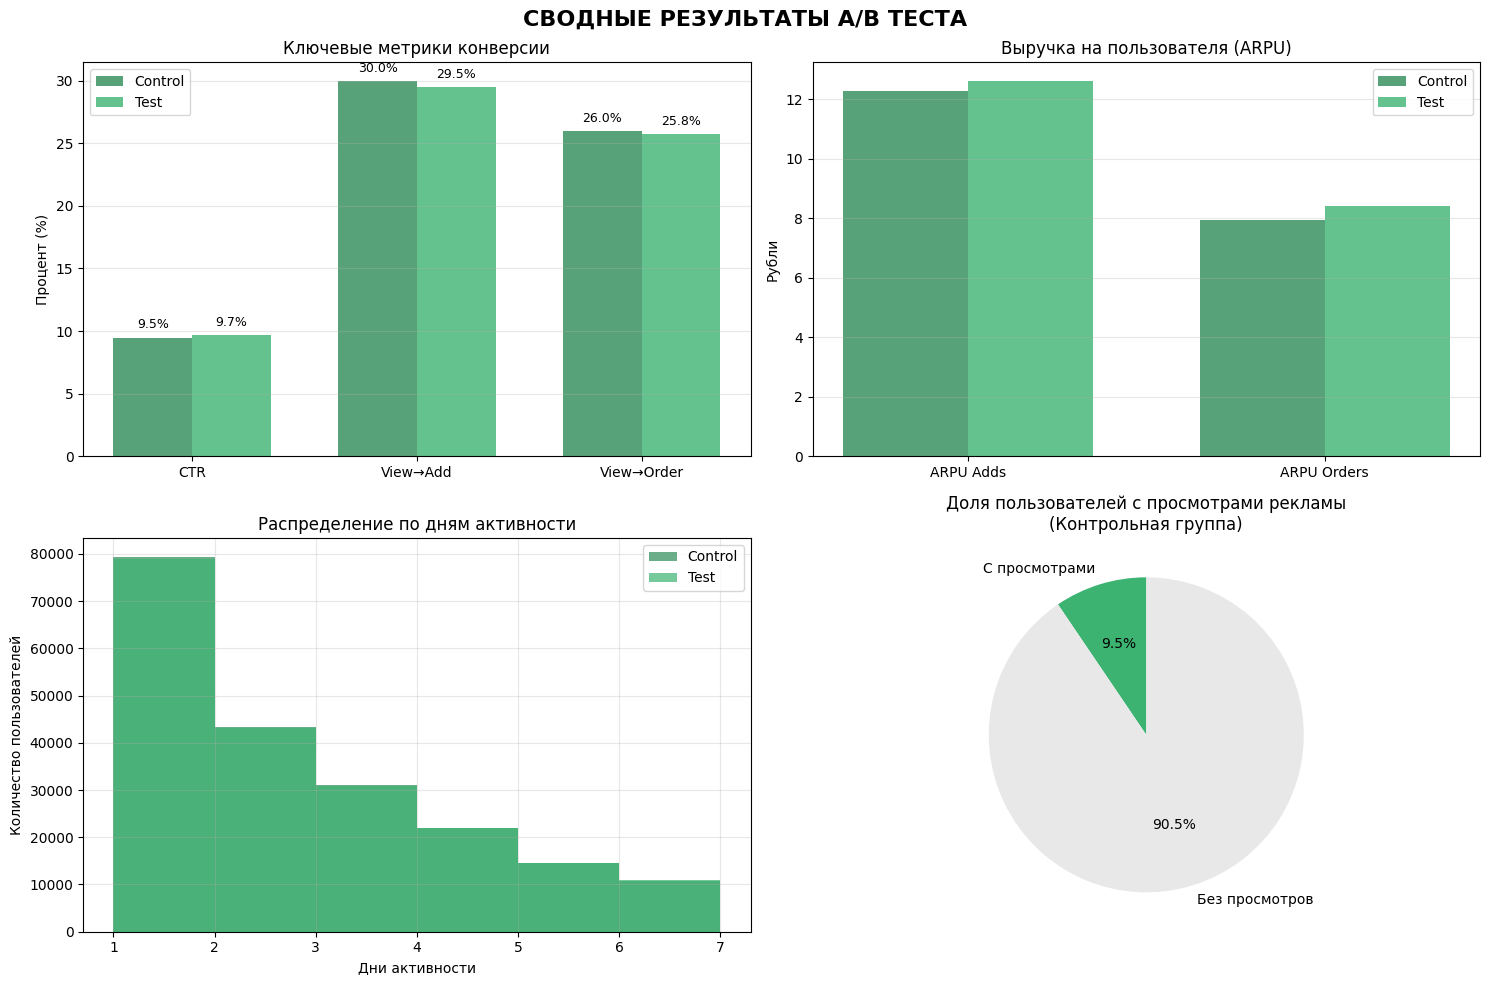

In [28]:
def create_summary_visualizations(control_metrics, test_metrics, user_detailed_metrics):
    """Создание сводных визуализаций для отчетов"""

    # Создаем сводную инфографику
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('СВОДНЫЕ РЕЗУЛЬТАТЫ A/B ТЕСТА', fontsize=16, fontweight='bold')

    # 1. Основные метрики
    metrics_to_compare = ['ctr_mean', 'view_to_add_rate', 'view_to_order_rate']
    metric_names = ['CTR', 'View→Add', 'View→Order']

    control_values = [control_metrics[m] * 100 for m in metrics_to_compare]
    test_values = [test_metrics[m] * 100 for m in metrics_to_compare]

    x = np.arange(len(metric_names))
    width = 0.35

    bars1 = ax1.bar(x - width/2, control_values, width, label='Control', color='#2E8B57', alpha=0.8)
    bars2 = ax1.bar(x + width/2, test_values, width, label='Test', color='#3CB371', alpha=0.8)

    ax1.set_ylabel('Процент (%)')
    ax1.set_title('Ключевые метрики конверсии')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metric_names)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # Добавляем значения на столбцы
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

    # 2. ARPU сравнение
    arpu_metrics = ['arpu_adds', 'arpu_orders']
    arpu_names = ['ARPU Adds', 'ARPU Orders']

    control_arpu = [control_metrics[m] for m in arpu_metrics]
    test_arpu = [test_metrics[m] for m in arpu_metrics]

    x_arpu = np.arange(len(arpu_names))
    bars1_arpu = ax2.bar(x_arpu - width/2, control_arpu, width, label='Control', color='#2E8B57', alpha=0.8)
    bars2_arpu = ax2.bar(x_arpu + width/2, test_arpu, width, label='Test', color='#3CB371', alpha=0.8)

    ax2.set_ylabel('Рубли')
    ax2.set_title('Выручка на пользователя (ARPU)')
    ax2.set_xticks(x_arpu)
    ax2.set_xticklabels(arpu_names)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)

    # 3. Распределение пользователей по активности
    activity_bins = [1, 2, 3, 4, 5, 6, 7]

    control_active_days = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'control']['active_days']
    test_active_days = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'test']['active_days']

    ax3.hist(control_active_days, bins=activity_bins, alpha=0.7, label='Control', color='#2E8B57')
    ax3.hist(test_active_days, bins=activity_bins, alpha=0.7, label='Test', color='#3CB371')
    ax3.set_xlabel('Дни активности')
    ax3.set_ylabel('Количество пользователей')
    ax3.set_title('Распределение по дням активности')
    ax3.legend()
    ax3.grid(alpha=0.3)

    # 4. Круговые диаграммы - доля пользователей с событиями
    events_data = [
        control_metrics['ctr_mean'] * control_metrics['n_users'],
        control_metrics['n_users'] - (control_metrics['ctr_mean'] * control_metrics['n_users'])
    ]

    events_labels = ['С просмотрами', 'Без просмотров']
    colors_pie = ['#3CB371', '#E8E8E8']

    ax4.pie(events_data, labels=events_labels, autopct='%1.1f%%', colors=colors_pie, startangle=90)
    ax4.set_title('Доля пользователей с просмотрами рекламы\n(Контрольная группа)')

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Финальный проект/summary_visualization.png',
                dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()

    return fig

# Создаем сводные визуализации
summary_fig = create_summary_visualizations(control_metrics, test_metrics, user_detailed_metrics)

Финальный запуск всех отчетов

НАЧИНАЕМ ГЕНЕРАЦИЮ ОТЧЕТОВ...
1. Создание текстового отчета...
2. Создание презентации...
3. Создание сводных визуализаций...


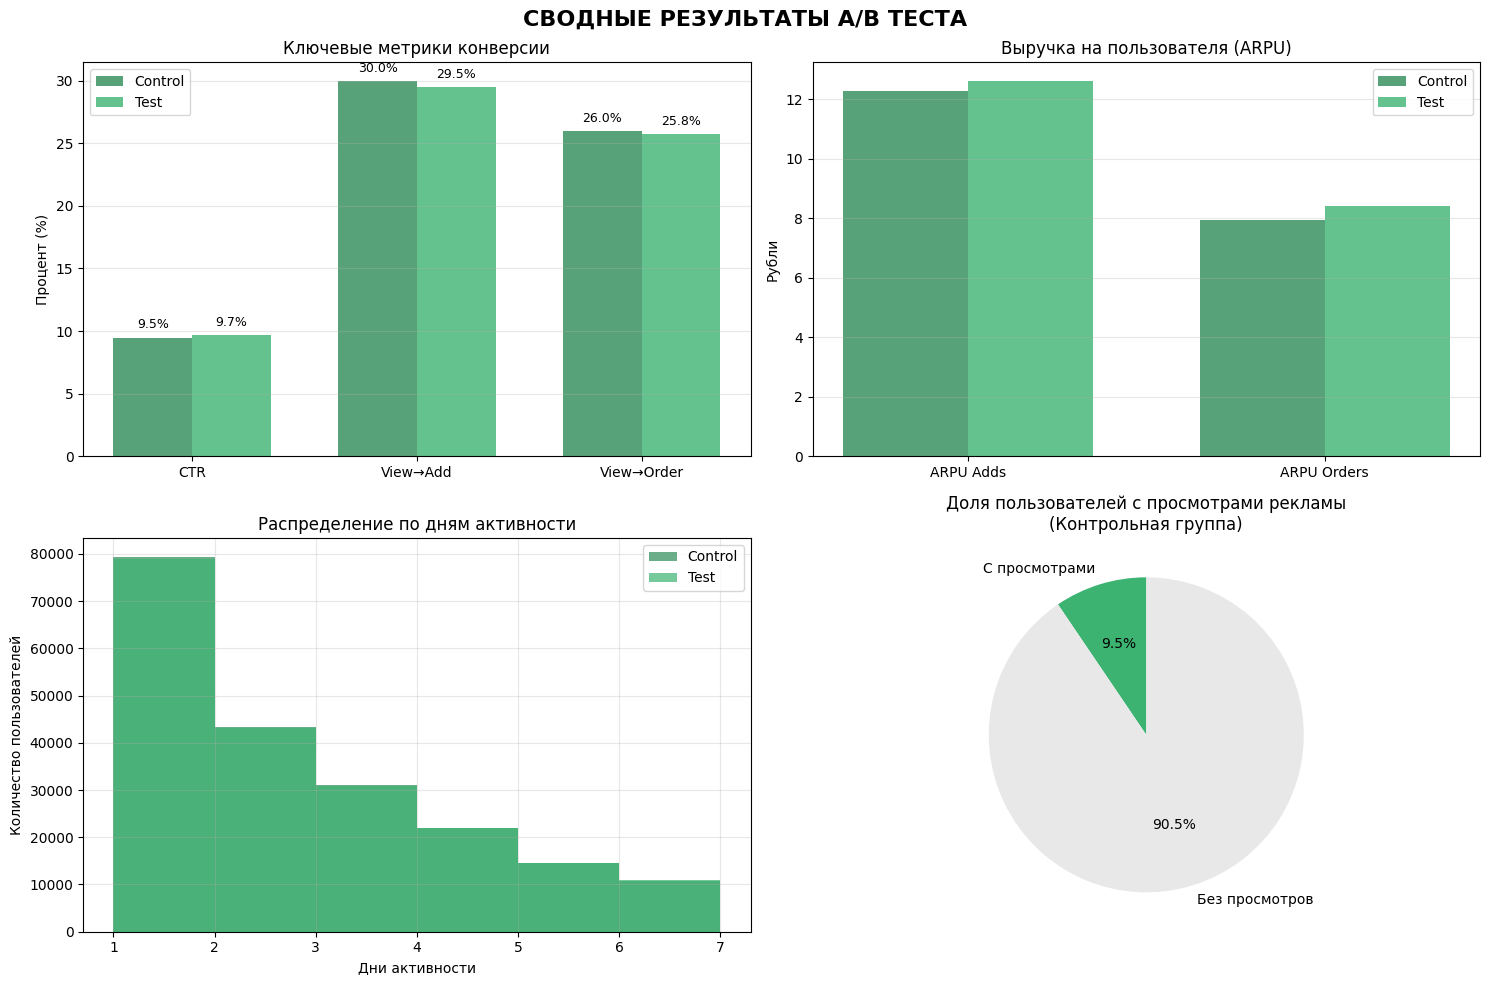


ОТЧЕТЫ УСПЕШНО СОЗДАНЫ!
Созданы следующие файлы:
1. /content/drive/MyDrive/Финальный проект/ab_test_report.txt
2. /content/drive/MyDrive/Финальный проект/ab_test_results_presentation.pptx
3. /content/drive/MyDrive/Финальный проект/summary_visualization.png

КРАТКАЯ СВОДКА РЕЗУЛЬТАТОВ:
CTR изменение: +2.11%
Статистическая значимость: p-value = 0.0315
Рекомендация: ВНЕДРИТЬ


In [29]:
def generate_final_reports():
    """Генерация всех финальных отчетов"""

    print("НАЧИНАЕМ ГЕНЕРАЦИЮ ОТЧЕТОВ...")
    print("="*50)

    # 1. Создаем дополнительные инсайты на основе анализа
    additional_insights = []

    # Анализ среднего чека
    users_with_orders = user_detailed_metrics[user_detailed_metrics['is_orders_ads'] == 1]
    if len(users_with_orders) > 0:
        control_orders = users_with_orders[users_with_orders['ab_group'] == 'control']
        test_orders = users_with_orders[users_with_orders['ab_group'] == 'test']

        if len(control_orders) > 0 and len(test_orders) > 0:
            aov_control = control_orders['sum_orders_ads'].sum() / control_orders['cnt_orders_ads'].sum()
            aov_test = test_orders['sum_orders_ads'].sum() / test_orders['cnt_orders_ads'].sum()
            aov_change = (aov_test - aov_control) / aov_control * 100
            additional_insights.append(f"Средний чек: {aov_change:+.1f}%")

    # Анализ активности
    active_days_control = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'control']['active_days'].mean()
    active_days_test = user_detailed_metrics[user_detailed_metrics['ab_group'] == 'test']['active_days'].mean()
    active_days_change = (active_days_test - active_days_control) / active_days_control * 100
    additional_insights.append(f"Дней активности на пользователя: {active_days_change:+.1f}%")

    # 2. Генерируем текстовый отчет
    print("1. Создание текстового отчета...")
    text_report = create_text_report(
        control_metrics, test_metrics, tests_df, user_detailed_metrics,
        ctr_relative_change, ctr_p_value, additional_insights
    )

    # 3. Генерируем презентацию
    print("2. Создание презентации...")
    presentation = create_presentation(
        control_metrics, test_metrics, tests_df, user_detailed_metrics,
        ctr_relative_change, ctr_p_value, additional_insights
    )

    # 4. Создаем визуализации
    print("3. Создание сводных визуализаций...")
    summary_fig = create_summary_visualizations(control_metrics, test_metrics, user_detailed_metrics)

    print("\n" + "="*50)
    print("ОТЧЕТЫ УСПЕШНО СОЗДАНЫ!")
    print("="*50)
    print("Созданы следующие файлы:")
    print("1. /content/drive/MyDrive/Финальный проект/ab_test_report.txt")
    print("2. /content/drive/MyDrive/Финальный проект/ab_test_results_presentation.pptx")
    print("3. /content/drive/MyDrive/Финальный проект/summary_visualization.png")

    return text_report, presentation

# Запускаем генерацию всех отчетов
text_report, presentation = generate_final_reports()

# Показываем краткую сводку
print("\nКРАТКАЯ СВОДКА РЕЗУЛЬТАТОВ:")
print(f"CTR изменение: {ctr_relative_change:+.2f}%")
print(f"Статистическая значимость: p-value = {ctr_p_value:.4f}")
print(f"Рекомендация: {'ВНЕДРИТЬ' if ctr_p_value < 0.05 and ctr_relative_change > 0 else 'ОТКЛОНИТЬ' if ctr_p_value < 0.05 and ctr_relative_change < 0 else 'ДОПОЛНИТЕЛЬНОЕ ИССЛЕДОВАНИЕ'}")

Дополнительная утилита для быстрого просмотра результатов

In [30]:
def create_executive_summary():
    """Создание краткого резюме для руководства"""

    summary = f"""
КРАТКОЕ РЕЗЮМЕ A/B ТЕСТА
{'='*40}

ЭКСПЕРИМЕНТ: Влияние расположения рекламного блока

РЕЗУЛЬТАТ:
• CTR: {ctr_relative_change:+.2f}% ({control_metrics['ctr_mean']*100:.2f}% → {test_metrics['ctr_mean']*100:.2f}%)
• Стат. значимость: {'ДА' if ctr_p_value < 0.05 else 'НЕТ'} (p-value: {ctr_p_value:.4f})
• Длительность: 7 дней
• Выборка: {control_metrics['n_users'] + test_metrics['n_users']:,} пользователей

ВЫВОД: {'УСПЕХ' if ctr_p_value < 0.05 and ctr_relative_change > 0 else 'НЕУДАЧА' if ctr_p_value < 0.05 and ctr_relative_change < 0 else 'НЕОПРЕДЕЛЕННО'}

РЕКОМЕНДАЦИЯ: {'Внедрить изменение' if ctr_p_value < 0.05 and ctr_relative_change > 0 else 'Отклонить изменение' if ctr_p_value < 0.05 and ctr_relative_change < 0 else 'Провести дополнительный анализ'}

СЛЕДУЮЩИЕ ШАГИ: {'Мониторинг после внедрения' if ctr_p_value < 0.05 and ctr_relative_change > 0 else 'Анализ причин и новая гипотеза' if ctr_p_value < 0.05 and ctr_relative_change < 0 else 'Эксперимент с увеличенной выборкой'}

Дата: {datetime.now().strftime('%d.%m.%Y')}
"""

    # Сохраняем краткое резюме
    with open('/content/drive/MyDrive/Финальный проект/executive_summary.txt', 'w', encoding='utf-8') as f:
        f.write(summary)

    print("Краткое резюме для руководства создано!")
    print(summary)

    return summary

# Создаем краткое резюме
exec_summary = create_executive_summary()

Краткое резюме для руководства создано!

КРАТКОЕ РЕЗЮМЕ A/B ТЕСТА

ЭКСПЕРИМЕНТ: Влияние расположения рекламного блока

РЕЗУЛЬТАТ:
• CTR: +2.11% (9.47% → 9.67%)
• Стат. значимость: ДА (p-value: 0.0315)
• Длительность: 7 дней
• Выборка: 401,260 пользователей

ВЫВОД: УСПЕХ

РЕКОМЕНДАЦИЯ: Внедрить изменение

СЛЕДУЮЩИЕ ШАГИ: Мониторинг после внедрения

Дата: 07.11.2025

